<a href="https://colab.research.google.com/github/erfunmirzaei/Social_Bandit/blob/main/Compare_Utility_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
import random
import gym
from scipy.stats import t
from statistics import mean
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Implementations

## Rewards

In [2]:
class MultinomialReward():
    def __init__(self, rewards, probs):
        self.rewards = rewards
        self.probs = probs

    def get_reward(self):
        return random.choices(self.rewards, weights = self.probs, k = 1)[0]
    
    def get_rewards(self):
        return self.rewards
    
    def get_probs(self):
        return self.probs

In [3]:
class DeteriministicReward():
    def __init__(self, reward):
        self.reward = reward

    def get_reward(self):
        return self.reward

In [4]:
class GaussianReward():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def get_reward(self):
        return np.random.normal(loc=self.mean, scale=self.std)

In [5]:
class Students_t_distReward():
    def __init__(self,dof, mean, std):
        self.dof = dof
        self.mean = mean
        self.std = std

    def get_reward(self):
        return t.rvs(df = self.dof, loc=self.mean, scale=self.std)

## N-Armed Bandit Environment

In [6]:
class MutliArmedBanditEnvironment():
    def __init__(self, rewards, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        self.action_space = action_space
        self.observation_space = state_space
        self.state = None
        self.id = id
        self.agents = {}
        
        if container != None:
            container.register_environment(self)
        self.arms_rewards = rewards # consits all rewards method
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def register_agent(self, agent):
        if type(agent.id) != str:
            raise Exception('Agent id must be a valid string.')
        if agent.id in self.agents.keys():
            raise Exception('An agent with the same id already exists.')
        
        self.agents[agent.id] = agent
        
    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward()

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action
    
    def get_info(self, action):
        return {} 

    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg

        reward = self.calculate_reward(action)
        info = self.get_info(action)
        self.next_state(action)
        done = self.terminated()
        observation = self.observe()
        return observation, reward, done, info

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

## Agents 

In [7]:
from abc import ABC, abstractmethod

class AgentBase:
    def __init__(self, id, environment=None):
        self.id = id
        self.environment = environment

    def set_environment(self, env):
        self.environment = env

    @abstractmethod
    def take_action(self) -> (object, float, bool, object):
        # in this method, you MUST call the `step` method of 
        # the environment and observe the results and return them like:
        # return observation, reward, done, info
        pass

In [8]:
import numpy as np

class EpsilonGreedyAgent(AgentBase):
    def __init__(self, id, environment, epsilon = 0.1,epsilon_decay = 1,alpha = 1,beta = 1,gamma = 1.5,optimistic = False):
        super(EpsilonGreedyAgent, self).__init__(id, environment)
        available_actions = self.environment.available_actions()
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.Q = np.zeros((available_actions,1))     #action value fuction
        self.N = np.zeros((available_actions,1))     #number of doing an action 

    def get_number_actions(self):
        return self.N

    def update(self,action,utility):
        self.epsilon = self.epsilon * self.epsilon_decay
        self.N[action] += 1
        self.Q[action] += (utility - self.Q[action])/self.N[action] 

    def utility_function(self,reward):
        if reward >= 0 :
            u = reward ** self.alpha
        else:
            u =  -1 * self.gamma * ((-reward)** self.beta)
        return u 
    
    def take_action(self) -> (object, float, bool, object):
        available_actions = self.environment.available_actions()
        rand = np.random.rand()
        if rand < self.epsilon:
            action = np.random.choice(available_actions)
        else:
            action = np.argmax(self.Q)
        
        obs, r, d, i = self.environment.step(action)
        #print("*",r)
        u = self.utility_function(r)
        self.update(action,u)
        #self.environment.render()
        return r, action , u


## Genetic Algorithm

In [ ]:
from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model

from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior

from geneticalgorithm2 import Population_initializer # for creating better start population

from geneticalgorithm2 import np_lru_cache # for cache function (if u want)

from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want

from geneticalgorithm2 import Callbacks # simple callbacks

from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

class Genetic_Algorithm():
    def __init__(self,agent,a_range,b_range,lamda_range,num_pop,variable_boundaries,env,\
                    optimal_action_index,variable_type='int'):  #a,b,lamda
        self.a = a_range
        self.b =  b_range
        self.lamda = lamda_range 
        self.N = num_pop
        self.varbounds = variable_boundaries
        self.dims = len(self.varbounds) 
        self.var_type = variable_type
        self.env = env 
        self.agent = agent 
        self.idx_opt_action = optimal_action_index

    def init_start_generation(self):
        start_generation = np.zeros((self.N, self.dims))
        for i in range(self.N):
            start_generation[i] = [np.random.choice(self.a),np.random.choice(self.b),np.random.choice(self.lamda)]
        return start_generation
    
    def fitness_function(self,X):
        #print(X)
        agent = self.agent(id ='1',environment = self.env,epsilon = 0.1,epsilon_decay = 0.99,
                            alpha = X[0]/10,beta = X[1]/10,gamma = X[2])
        optimal_selection = [0]
        trial_cnt = 0
        percent_counter = 0
        while True:
            trial_cnt = trial_cnt + 1
            Ri, index_selected_arm, ui = agent.take_action()
            optimal_selection.append(optimal_selection[-1]+int(index_selected_arm==self.idx_opt_action))
            if optimal_selection[-1]/(trial_cnt) > 0.9:
                percent_counter = percent_counter + 1
                if percent_counter > 30:
                    print(trial_cnt,[X[0]/10,X[1]/10,X[2]])
                    return  trial_cnt
            else:
                percent_counter = 0
            if trial_cnt > 1000:
                return 1000

    def my_mutation(self,current_value, left_border, right_border):
        #print("muting")
        #print(current_value, left_border, right_border)
        return current_value
    
    def my_crossover(self,parent_a, parent_b):
        index = np.random.choice(self.dims)
        child_1 = []
        child_2 = []
        for i in range(self.dims):
            if i < index:
                child_1.append(parent_a[i])
                child_2.append(parent_b[i])
            else:
                child_1.append(parent_b[i])
                child_2.append(parent_a[i])
        return np.array(child_1), np.array(child_2)
    
    def train(self):
        start_generation = self.init_start_generation()
        model = ga(function = self.fitness_function, dimension = self.dims, variable_type = self.var_type,
                variable_boundaries = self.varbounds ,variable_type_mixed = None, function_timeout = 10,
                 algorithm_parameters={'max_num_iteration': None,
                                       'population_size':self.N,
                                       'mutation_probability':0.1,
                                       'elit_ratio': 0.01,
                                       'crossover_probability': 0.5,
                                       'parents_portion': 0.3,
                                       'crossover_type':self.my_crossover,
                                       'mutation_type': self.my_mutation,
                                       'selection_type': 'roulette',
                                       'max_iteration_without_improv':None}
            )
        model.run(no_plot = False, start_generation={'variables': start_generation, 'scores': None})
        convergence = model.report
        return convergence


ModuleNotFoundError: ignored

In [ ]:
a_range = np.linspace(0.01,10,20)
b_range = np.linspace(0.01,10,20)
lamda_range = np.linspace(0.01,10,20)

varbound_list = np.array([[0.01,10],[0.01,10],[0.01,10]])
rewards = [DeteriministicReward(1.1),DeteriministicReward(1)]
env = MutliArmedBanditEnvironment(rewards, episode_max_length = 1000, id = '1')
g = Genetic_Algorithm(EpsilonGreedyAgent,a_range,b_range,lamda_range,num_pop = 1000,
                      variable_boundaries = varbound_list,env = env, optimal_action_index = 0)
g.train()

NameError: ignored

9, 0.2, 2.0]
31 [0.2, 0.1, 5.0]
31 [0.2, 0.5, 1.0]
51 [0.9, 0.4, 5.0]
171 [0.8, 0.3, 5.0]
31 [0.7, 0.5, 0.0]
61 [0.5, 0.3, 3.0]
51 [0.7, 0.9, 1.0]
71 [0.6, 0.2, 3.0]
201 [0.1, 0.4, 1.0]
41 [0.7, 0.9, 5.0]
31 [0.2, 0.2, 3.0]
31 [0.7, 0.2, 5.0]
91 [0.2, 0.3, 2.0]
31 [0.2, 0.4, 5.0]
51 [0.2, 0.3, 1.0]
31 [0.8, 0.3, 7.0]
31 [0.7, 1.0, 6.0]
31 [0.9, 0.4, 1.0]
31 [0.2, 0.3, 3.0]
41 [0.7, 0.2, 8.0]
31 [0.2, 0.2, 1.0]
31 [0.7, 0.3, 4.0]
31 [0.1, 0.5, 4.0]
51 [0.9, 0.9, 3.0]
31 [0.8, 0.3, 5.0]
51 [0.9, 0.7, 9.0]
31 [0.5, 0.2, 7.0]
31 [0.2, 0.9, 1.0]
41 [0.5, 0.2, 3.0]
61 [0.6, 0.2, 4.0]
41 [0.7, 0.4, 1.0]
31 [0.7, 0.3, 1.0]
61 [0.9, 0.2, 5.0]
61 [0.9, 0.3, 7.0]
41 [0.2, 0.2, 5.0]
41 [0.2, 0.3, 5.0]
31 [0.7, 0.3, 3.0]
51 [0.2, 0.5, 6.0]
31 [0.8, 0.3, 1.0]
31 [0.7, 0.3, 2.0]
71 [0.7, 0.9, 1.0]
31 [0.5, 0.3, 2.0]
71 [0.9, 0.3, 5.0]
31 [0.2, 0.8, 5.0]
81 [0.7, 0.2, 3.0]
31 [0.7, 0.7, 4.0]
31 [0.5, 0.2, 5.0]
31 [0.5, 0.2, 4.0]
41 [0.5, 0.3, 3.0]
31 [0.8, 0.9, 5.0]
31 [0.7, 0.3, 4.0]
31 [0.5, 0.2, 2.

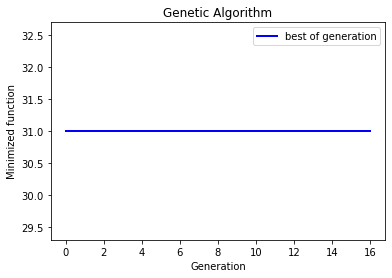

[31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0]

In [ ]:
a_range = np.arange(1, 10)
b_range  = np.arange(1, 10)
lamda_range = np.arange(1, 10)

varbound_list = np.array([[1,10],[1,10],[0,10]])
rewards = [DeteriministicReward(1.1),DeteriministicReward(1)]
env = MutliArmedBanditEnvironment(rewards, episode_max_length = 1000, id = '1')
g = Genetic_Algorithm(EpsilonGreedyAgent,a_range,b_range,lamda_range,num_pop = 500,
                      variable_boundaries = varbound_list,env = env, optimal_action_index = 0)
g.train()

# 2-armed Bandit 

## Sampling

In [ ]:
def utility_function(reward,alpha,beta,lamda):
    if reward >= 0 :
        u = reward ** alpha
    else:
        u =  -1 * lamda * ((-reward)** beta)
    return u 

In [ ]:
# function to return key for any value
def get_policies(my_dict, val):
    pi = []
    for key, value in my_dict.items():
         if val == value:
             x = key.split(sep = ',')
             a = float(x[0].split(sep = ':')[1])
             b = float(x[1].split(sep = ':')[1])
             l = float(x[2].split(sep = ':')[1])
             pi.append((a,b,l))
    return pi 

### Deterministic Rewards

In [ ]:
Deterministic_Rewards = {'2pos_near' : [DeteriministicReward(1.1),DeteriministicReward(1)],
                         '2pos_close': [DeteriministicReward(2),DeteriministicReward(1)],
                         '2pos_far': [DeteriministicReward(4),DeteriministicReward(1)],
                         'zero_pos_near' : [DeteriministicReward(0.1),DeteriministicReward(0)],
                         'zero_pos_close': [DeteriministicReward(1),DeteriministicReward(0)],
                         'zero_pos_far': [DeteriministicReward(3),DeteriministicReward(0)],
                         'neg_pos_near' : [DeteriministicReward(0.1),DeteriministicReward(-0.1)],
                         'neg_pos_close': [DeteriministicReward(0.5),DeteriministicReward(-0.5)],
                         'neg_pos_far': [DeteriministicReward(2),DeteriministicReward(-2)]} 
idx_opt_act = 0 
UFs = {}
for i in [0.01, 0.1, 0.3, 0.5, 0.7, 0.9 , 1, 2]:
    for j in [0.01, 0.1, 0.3, 0.5, 0.7, 0.9 , 1, 2]:
        for k in [-2, -1, 0, 0.1,0.3,0.5,1,3,5,7,9,10]:
            UFs['a:'+str(i)+',b:'+str(j)+',l:'+str(k)] = [i,j,k]

UFs['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(20)] = [0.9,0.9,20]
UFs['a:'+str(0.01)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.01,0.01,2.25]
UFs['a:'+str(0.01)+',b:'+str(0.9)+',l:'+str(2.25)] = [0.01,0.9,2.25]
UFs['a:'+str(0.9)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.9,0.01,2.25]

#### average utility and zero initialization 

In [ ]:
Det_Convg_trials = {}
Det_policy = {}

for j in tqdm(range(len(Deterministic_Rewards))): 
    Rew = list(Deterministic_Rewards.values())[j]
    Det_Convg_trials[list(Deterministic_Rewards.keys())[j]] = {}
    Det_policy[list(Deterministic_Rewards.keys())[j]] = {}

    for i in tqdm(range(len(UFs))):
        Q = np.zeros((len(Rew),50,1000))
        for r in range(50):
            avg = [0] * len(Rew) 
            uf = list(UFs.values())[i]
            for t in range(1000):
                for k in range(len(Rew)):
                    rew = Rew[k].get_reward()
                    u = utility_function(rew,uf[0],uf[1],uf[2])
                    avg[k] += (u - avg[k]) / (t+1) # alpha = cte 
                    Q[k,r,t] = avg[k]

        means = np.mean(Q,axis = 1)  
        stds = np.std(Q,axis = 1, ddof = 1)
        upper = means + 1.96 * stds
        lower = means - 1.96 * stds

        times = np.where((lower[idx_opt_act,:] > np.amax(upper,axis = 0 )).astype(int) == 0 )
        t_star = times[0][-1] + 2

        Det_Convg_trials[list(Deterministic_Rewards.keys())[j]][list(UFs.keys())[i]] = t_star

        if t_star == 1001 : 
            Det_policy[list(Deterministic_Rewards.keys())[j]][list(UFs.keys())[i]] = -1
        else :
            Det_policy[list(Deterministic_Rewards.keys())[j]][list(UFs.keys())[i]] = 1 

Streaming output truncated to the last 5000 lines.
100%|██████████| 9/9 [21:44<00:00, 144.91s/it]


In [ ]:
Det_Convg_trials_file = open('/content/drive/My Drive/Det_Convg_trials.csv', "w")

writer = csv.writer(Det_Convg_trials_file)
for key, value in Det_Convg_trials.items():
    writer.writerow([key, value])

Det_Convg_trials_file.close()

In [ ]:
Det_policy_file = open('/content/drive/My Drive/Det_policy.csv', "w")

writer = csv.writer(Det_policy_file)
for key, value in Det_policy.items():
    writer.writerow([key, value])

Det_policy_file.close()

#### exponential moving average utility and zero initialization 

In [ ]:
Det_Convg_trials2 = {}
Det_policy2 = {}

for j in tqdm(range(len(Deterministic_Rewards))): 
    Rew = list(Deterministic_Rewards.values())[j]
    Det_Convg_trials2[list(Deterministic_Rewards.keys())[j]] = {}
    Det_policy2[list(Deterministic_Rewards.keys())[j]] = {}

    for i in range(len(UFs)):
        Q = np.zeros((len(Rew),50,1000))
        for r in range(50):
            avg = [0] * len(Rew) 
            uf = list(UFs.values())[i]
            for t in range(1000):
                for k in range(len(Rew)):
                    rew = Rew[k].get_reward()
                    u = utility_function(rew,uf[0],uf[1],uf[2])
                    avg[k] += (u - avg[k]) * 0.1 # alpha = cte 
                    Q[k,r,t] = avg[k]

        means = np.mean(Q,axis = 1)  
        stds = np.std(Q,axis = 1, ddof = 1)
        upper = means + 1.96 * stds
        lower = means - 1.96 * stds

        times = np.where((lower[idx_opt_act,:] > np.amax(upper,axis = 0 )).astype(int) == 0 )
        t_star = times[0][-1] + 2

        Det_Convg_trials2[list(Deterministic_Rewards.keys())[j]][list(UFs.keys())[i]] = t_star

        if t_star == 1001 : 
            Det_policy2[list(Deterministic_Rewards.keys())[j]][list(UFs.keys())[i]] = -1
        else :
            Det_policy2[list(Deterministic_Rewards.keys())[j]][list(UFs.keys())[i]] = 1 

In [ ]:
Det_Convg_trials_file2 = open('/content/drive/My Drive/Det_Convg_trials2.csv', "w")

writer = csv.writer(Det_Convg_trials_file2)
for key, value in Det_Convg_trials2.items():
    writer.writerow([key, value])

Det_Convg_trials_file2.close()

In [ ]:
Det_policy_file2 = open('/content/drive/My Drive/Det_policy2.csv', "w")

writer = csv.writer(Det_policy_file2)
for key, value in Det_policy2.items():
    writer.writerow([key, value])

Det_policy_file2.close()

In [ ]:
cluster uf with policy values (show in figure??)
sort dic and find 10 best , 10 worst for each policy

SyntaxError: ignored

### Bernouli Rewards

In [19]:
Multinomial_Rewards1 = {
                    '0-1-1': [MultinomialReward([0,1],[0.5,0.5]), MultinomialReward([0,1],[0.6,0.4])],
                    '0-1-2': [MultinomialReward([0,1],[0.5,0.5]), MultinomialReward([0,1],[0.7,0.3])],
                    '0-1-3': [MultinomialReward([0,1],[0.5,0.5]), MultinomialReward([0,1],[0.8,0.2])],
                    '0-1-4': [MultinomialReward([0,1],[0.5,0.5]), MultinomialReward([0,1],[0.9,0.1])],
                    '0-1-5': [MultinomialReward([0,1],[0.2,0.8]), MultinomialReward([0,1],[0.3,0.7])],
                    '0-1-6': [MultinomialReward([0,1],[0.2,0.8]), MultinomialReward([0,1],[0.4,0.6])],
                    '0-1-7': [MultinomialReward([0,1],[0.2,0.8]), MultinomialReward([0,1],[0.5,0.5])],
                    '0-1-8': [MultinomialReward([0,1],[0.2,0.8]), MultinomialReward([0,1],[0.6,0.4])],
}

Multinomial_Rewards2 = {
                    '0-10-1': [MultinomialReward([0,10],[0.5,0.5]), MultinomialReward([0,10],[0.6,0.4])],
                    '0-10-2': [MultinomialReward([0,10],[0.5,0.5]), MultinomialReward([0,10],[0.7,0.3])],
                    '0-10-3': [MultinomialReward([0,10],[0.5,0.5]), MultinomialReward([0,10],[0.8,0.2])],
                    '0-10-4': [MultinomialReward([0,10],[0.5,0.5]), MultinomialReward([0,10],[0.9,0.1])],
                    '0-10-5': [MultinomialReward([0,10],[0.2,0.8]), MultinomialReward([0,10],[0.3,0.7])],
                    '0-10-6': [MultinomialReward([0,10],[0.2,0.8]), MultinomialReward([0,10],[0.4,0.6])],
                    '0-10-7': [MultinomialReward([0,10],[0.2,0.8]), MultinomialReward([0,10],[0.5,0.5])],
                    '0-10-8': [MultinomialReward([0,10],[0.2,0.8]), MultinomialReward([0,10],[0.6,0.4])],
}

Multinomial_Rewards3 = {
                    '10-2-1': [MultinomialReward([10,2],[0.8,0.2]), MultinomialReward([10,2],[0.6,0.4])],
                    '10-2-2': [MultinomialReward([10,2],[0.8,0.2]), MultinomialReward([10,2],[0.4,0.6])],
                    '10-2-3': [MultinomialReward([10,2],[0.8,0.2]), MultinomialReward([10,2],[0.2,0.8])],
}

Multinomial_Rewards4 = {
                    '100-2-1': [MultinomialReward([100,2],[0.8,0.2]), MultinomialReward([100,2],[0.6,0.4])],
                    '100-2-2': [MultinomialReward([100,2],[0.8,0.2]), MultinomialReward([100,2],[0.4,0.6])],
                    '100-2-3': [MultinomialReward([100,2],[0.8,0.2]), MultinomialReward([100,2],[0.2,0.8])],
}

idx_opt_act = 0 
UFs = {}
for i in [0.01, 0.1, 0.3, 0.5, 0.7, 0.9 , 1]:
    for j in [0.01, 0.1, 0.3, 0.5, 0.7, 0.9 , 1]:
        for k in [1,2,3,5,7,9,10]:
            UFs['a:'+str(i)+',b:'+str(j)+',l:'+str(k)] = [i,j,k]
           
# UFs['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(20)] = [0.9,0.9,20]
# UFs['a:'+str(0.01)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.01,0.01,2.25]
# UFs['a:'+str(0.01)+',b:'+str(0.9)+',l:'+str(2.25)] = [0.01,0.9,2.25]
# UFs['a:'+str(0.9)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.9,0.01,2.25]

In [14]:
def utility_function(reward,  alpha, beta, gamma):
    if reward >= 0 :
        u = reward ** alpha
    else:
        u =  -1 * gamma * ((-reward)** beta)
    return u 

def argmax_exp_utility(rewards, probs, alpha, beta, lamda):
    EU = []
    for reward, prob in zip(rewards, probs):
        util = list(map(lambda x:utility_function(x,alpha, beta, lamda), reward))
        EU.append(np.array(util) @ np.array(prob))
    
    EU = np.array(EU)
    return np.flatnonzero(EU == EU.max()) [0]

# function to return key for any value
def get_policies(my_dict, val):
    pi = []
    keys = []
    for key, value in my_dict.items():
         if val == value:
             x = key.split(sep = ',')
             a = float(x[0].split(sep = ':')[1])
             b = float(x[1].split(sep = ':')[1])
             l = float(x[2].split(sep = ':')[1])
             pi.append((a,b,l))
             keys.append(key)
    return pi,keys

In [15]:
def EU_experiments(Multinomial_Rewards, convergence_level):
    Mult_Avg_Rewards = {}
    Mult_Convg_trials = {} 
    Mult_Perc_optimal = {}
    Mult_policy = {} 

    for j in tqdm(range(len(Multinomial_Rewards))): 
        Rew = list(Multinomial_Rewards.values())[j]
        rews= [x.get_rewards() for x in Rew]
        probs= [x.get_probs() for x in Rew]
        env = MutliArmedBanditEnvironment(Rew, episode_max_length = 1000, id = '1')
        env.reset()
        Mult_Convg_trials[list(Multinomial_Rewards.keys())[j]] = {}
        Mult_Avg_Rewards[list(Multinomial_Rewards.keys())[j]] = {}
        Mult_Perc_optimal[list(Multinomial_Rewards.keys())[j]] = {}
        Mult_policy[list(Multinomial_Rewards.keys())[j]] = {}
        for i in range(len(UFs)):
            convergance_trials = []
            avg_rewards = []
            perc_optimal = []
            uf = list(UFs.values())[i]
            ind = argmax_exp_utility(rews, probs,uf[0],uf[1],uf[2])
            Mult_policy[list(Multinomial_Rewards.keys())[j]][list(UFs.keys())[i]] = ind
            for r in range(200):
                opt_act_count = 0
                avg = 0 #list(np.zeros(len(rewards),1))
                agent = EpsilonGreedyAgent(str(i),env,0.1,1,uf[0],uf[1],uf[2])
                consecutive_cnt = 0
                for t in range(1000):
                    rew , idx_act , u = agent.take_action()
                    
                    avg += (rew - avg) / (t+1)

                    opt_act_count += int(idx_act == idx_opt_act)

                    if opt_act_count /(t+1) > convergence_level:
                        consecutive_cnt += 1
                        if consecutive_cnt > 5:
                            break 
                    else : 
                        consecutive_cnt = 0
                
                convergance_trials.append(t+1)
                perc_optimal.append(opt_act_count / (t+1))
                avg_rewards.append(avg)
            
            Mult_Convg_trials[list(Multinomial_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(convergance_trials)
            Mult_Perc_optimal[list(Multinomial_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(perc_optimal)
            Mult_Avg_Rewards[list(Multinomial_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(avg_rewards)

    mean_convg_time_alpha = {}
    for rew in list(Mult_Convg_trials.keys()):
        mean_convg_time_alpha[rew] = []
        for j in range(7):
            mean_convg_time_alpha[rew].append(mean(list(Mult_Convg_trials[rew].values())[j*49:(j+1)*49])) 

    Mult_pi_1 = {} 
    Mult_pi_2 = {} 

    Mult_pi_1_s = {} 
    Mult_pi_2_s = {} 

    for rew in list(Multinomial_Rewards.keys()):
        pi_1,keys1 = get_policies(Mult_policy[rew], 0)
        pi_2,keys2 = get_policies(Mult_policy[rew], 1)
        
        pi_1_1_a = [item[0] for item in pi_1 if item[2] == 1]
        pi_1_1_b = [item[1] for item in pi_1 if item[2] == 1]
        pi_1_1_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys1,pi_1)  if item[2] == 1]
        pi_2_1_a = [item[0] for item in pi_2 if item[2] == 1]
        pi_2_1_b = [item[1] for item in pi_2 if item[2] == 1]    
        pi_2_1_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys2,pi_2)  if item[2] == 1]

        pi_1_2_a = [item[0] for item in pi_1 if item[2] == 2]
        pi_1_2_b = [item[1] for item in pi_1 if item[2] == 2]
        pi_1_2_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys1,pi_1)  if item[2] == 2]
        pi_2_2_a = [item[0] for item in pi_2 if item[2] == 2]
        pi_2_2_b = [item[1] for item in pi_2 if item[2] == 2]    
        pi_2_2_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys2,pi_2)  if item[2] == 2]  
        
        pi_1_3_a = [item[0] for item in pi_1 if item[2] == 3]
        pi_1_3_b = [item[1] for item in pi_1 if item[2] == 3]
        pi_1_3_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys1,pi_1)  if item[2] == 3]
        pi_2_3_a = [item[0] for item in pi_2 if item[2] == 3]
        pi_2_3_b = [item[1] for item in pi_2 if item[2] == 3]  
        pi_2_3_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys2,pi_2)  if item[2] == 3]
        
        pi_1_5_a = [item[0] for item in pi_1 if item[2] == 5]
        pi_1_5_b = [item[1] for item in pi_1 if item[2] == 5]
        pi_1_5_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys1,pi_1)  if item[2] == 5]
        pi_2_5_a = [item[0] for item in pi_2 if item[2] == 5]
        pi_2_5_b = [item[1] for item in pi_2 if item[2] == 5]  
        pi_2_5_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys2,pi_2)  if item[2] == 5]

        pi_1_7_a = [item[0] for item in pi_1 if item[2] == 7]
        pi_1_7_b = [item[1] for item in pi_1 if item[2] == 7]
        pi_1_7_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys1,pi_1)  if item[2] == 7]
        pi_2_7_a = [item[0] for item in pi_2 if item[2] == 7]
        pi_2_7_b = [item[1] for item in pi_2 if item[2] == 7]
        pi_2_7_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys2,pi_2)  if item[2] == 7]  

        pi_1_9_a = [item[0] for item in pi_1 if item[2] == 9]
        pi_1_9_b = [item[1] for item in pi_1 if item[2] == 9]
        pi_1_9_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys1,pi_1)  if item[2] == 9]
        pi_2_9_a = [item[0] for item in pi_2 if item[2] == 9]
        pi_2_9_b = [item[1] for item in pi_2 if item[2] == 9] 
        pi_2_9_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys2,pi_2)  if item[2] == 9]

        pi_1_10_a = [item[0] for item in pi_1 if item[2] == 10]
        pi_1_10_b = [item[1] for item in pi_1 if item[2] == 10]
        pi_1_10_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys1,pi_1)  if item[2] == 10]
        pi_2_10_a = [item[0] for item in pi_2 if item[2] == 10]
        pi_2_10_b = [item[1] for item in pi_2 if item[2] == 10]
        pi_2_10_s = [Mult_Convg_trials[rew][key] for key,item in zip(keys2,pi_2)  if item[2] == 10]   

        Mult_pi_1[rew] = [pi_1_1_a,pi_1_1_b, pi_1_2_a,pi_1_2_b,pi_1_3_a,pi_1_3_b,
                        pi_1_5_a,pi_1_5_b, pi_1_7_a,pi_1_7_b,
                        pi_1_9_a,pi_1_9_b, pi_1_10_a,pi_1_10_b]
        
        Mult_pi_2[rew] = [pi_2_1_a,pi_2_1_b,pi_2_2_a,pi_2_2_b,pi_2_3_a,pi_2_3_b,
                        pi_2_5_a,pi_2_5_b,pi_2_7_a,pi_2_7_b,
                        pi_2_9_a,pi_2_9_b,pi_2_10_a,pi_2_10_b]
        
        Mult_pi_1_s[rew] = [pi_1_1_s,pi_1_2_s,pi_1_3_s,pi_1_5_s,pi_1_7_s,pi_1_9_s,pi_1_10_s]
        Mult_pi_2_s[rew] = [pi_2_1_s,pi_2_2_s,pi_2_3_s,pi_2_5_s,pi_2_7_s,pi_2_9_s,pi_2_10_s]  

    return    Mult_Convg_trials, mean_convg_time_alpha, Mult_pi_1,  Mult_pi_2,  Mult_pi_1_s,  Mult_pi_2_s

def plot_scatter(x1, y1, x2, y2, s1, s2, rew, lamda):
    fig, ax = plt.subplots(figsize = (8,6))
    ax.scatter(x1, y1, s = s1)
    ax.scatter(x2, y2, s = s2, color = 'r')

    plt.xlabel("alpha",fontsize = 14)
    plt.ylabel("beta",fontsize = 14)
    plt.title(rew + f", lamda = {lamda}")
    plt.show()

In [17]:
Mult_Convg_trials_1, mean_convg_time_alpha_1, Mult_pi_1_1,  Mult_pi_2_1,  Mult_pi_1_s_1,  Mult_pi_2_s_1 = EU_experiments(Multinomial_Rewards3, 0.7)
Mult_Convg_trials_2, mean_convg_time_alpha_2, Mult_pi_1_2,  Mult_pi_2_2,  Mult_pi_1_s_2,  Mult_pi_2_s_2 = EU_experiments(Multinomial_Rewards3, 0.9)

100%|██████████| 3/3 [06:23<00:00, 127.76s/it]


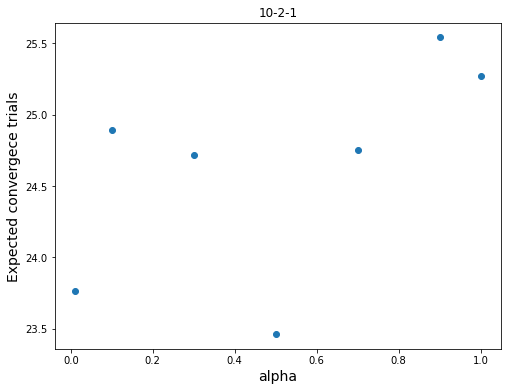

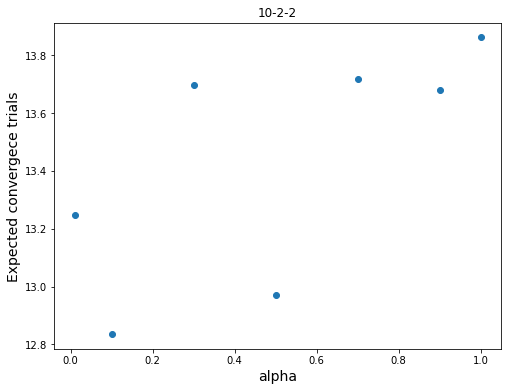

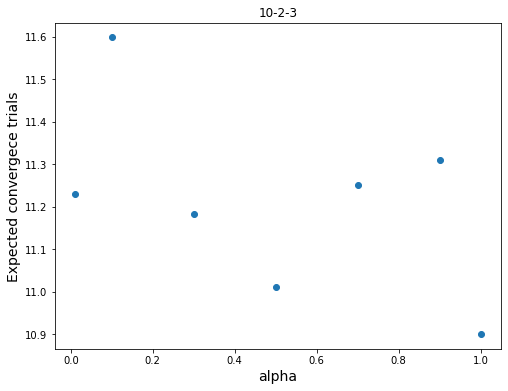

In [18]:
for rew in list(Multinomial_Rewards3.keys()):
    fig, ax = plt.subplots(figsize = (8,6))
    ax.scatter([0.01, 0.1, 0.3, 0.5, 0.7, 0.9 , 1], mean_convg_time_alpha_1[rew])
    plt.xlabel("alpha",fontsize = 14)
    plt.ylabel("Expected convergece trials",fontsize = 14)
    plt.title(rew)
    plt.show()

In [20]:
Mult_Convg_trials_3, mean_convg_time_alpha_3, Mult_pi_1_3,  Mult_pi_2_3,  Mult_pi_1_s_3,  Mult_pi_2_s_3 = EU_experiments(Multinomial_Rewards4, 0.7)
Mult_Convg_trials_4, mean_convg_time_alpha_4, Mult_pi_1_4,  Mult_pi_2_4,  Mult_pi_1_s_4,  Mult_pi_2_s_4 = EU_experiments(Multinomial_Rewards4, 0.9)

100%|██████████| 3/3 [06:26<00:00, 128.98s/it]


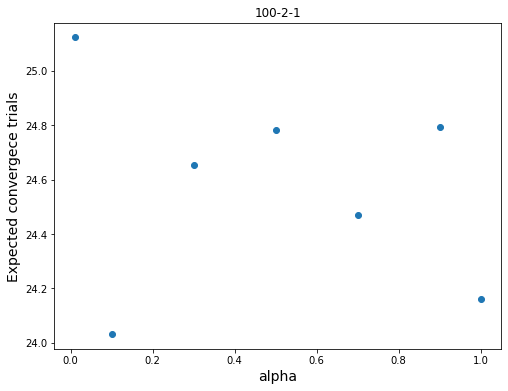

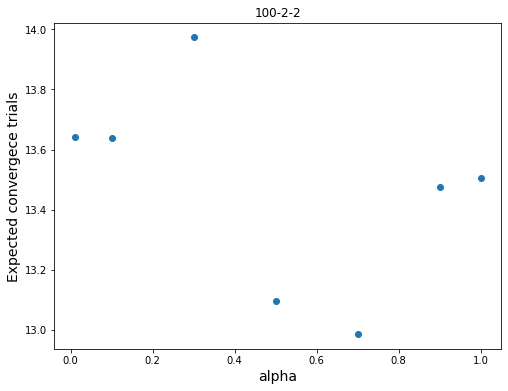

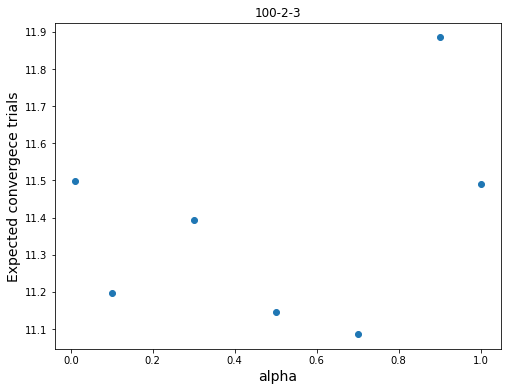

In [21]:
for rew in list(Multinomial_Rewards4.keys()):
    fig, ax = plt.subplots(figsize = (8,6))
    ax.scatter([0.01, 0.1, 0.3, 0.5, 0.7, 0.9 , 1], mean_convg_time_alpha_3[rew])
    plt.xlabel("alpha",fontsize = 14)
    plt.ylabel("Expected convergece trials",fontsize = 14)
    plt.title(rew)
    plt.show()

In [ ]:
Mult_Convg_trials_1, mean_convg_time_alpha_1, Mult_pi_1_1,  Mult_pi_2_1,  Mult_pi_1_s_1,  Mult_pi_2_s_1 = EU_experiments(Multinomial_Rewards1, 0.7)
Mult_Convg_trials_2, mean_convg_time_alpha_2, Mult_pi_1_2,  Mult_pi_2_2,  Mult_pi_1_s_2,  Mult_pi_2_s_2 = EU_experiments(Multinomial_Rewards1, 0.9)

Mult_Convg_trials_3, mean_convg_time_alpha_3, Mult_pi_1_3,  Mult_pi_2_3,  Mult_pi_1_s_3,  Mult_pi_2_s_3 = EU_experiments(Multinomial_Rewards2, 0.7)
Mult_Convg_trials_4, mean_convg_time_alpha_4, Mult_pi_1_4,  Mult_pi_2_4,  Mult_pi_1_s_4,  Mult_pi_2_s_4 = EU_experiments(Multinomial_Rewards2, 0.9)

100%|██████████| 8/8 [15:10<00:00, 113.80s/it]


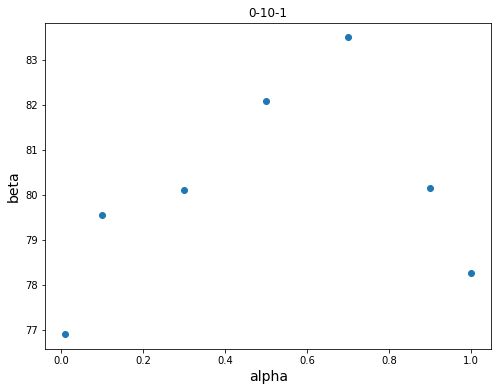

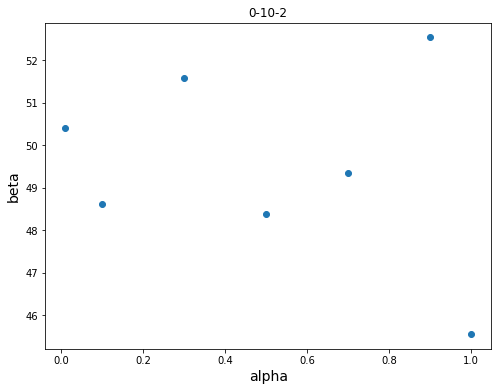

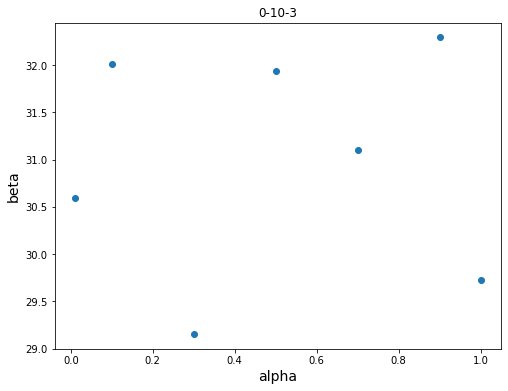

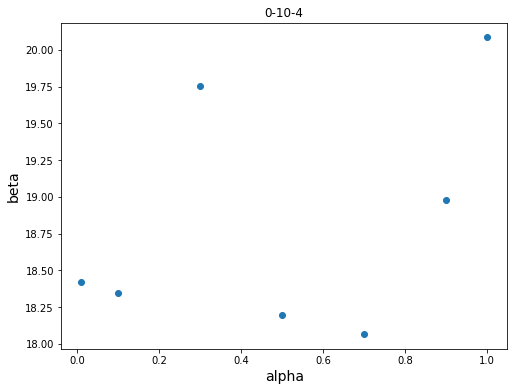

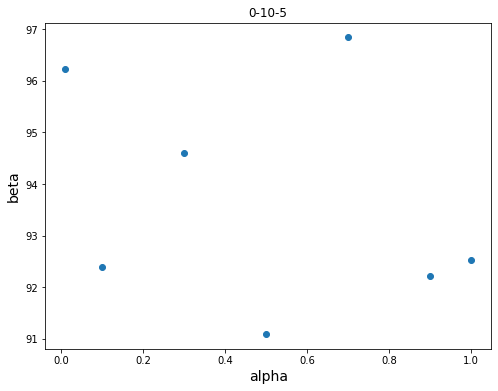

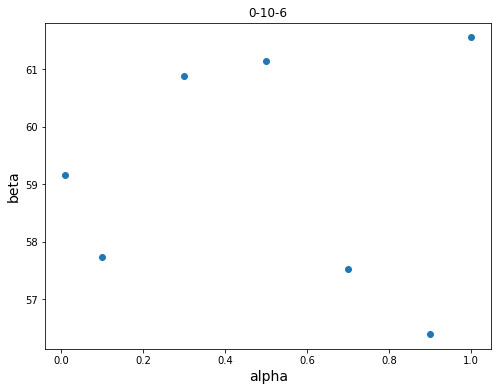

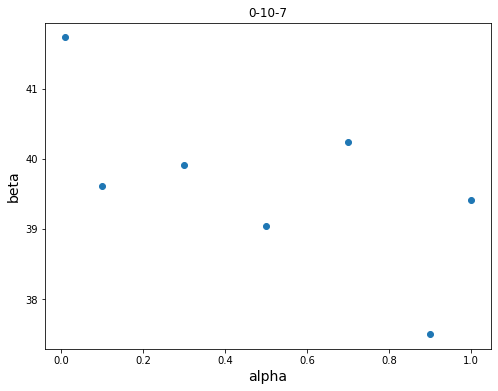

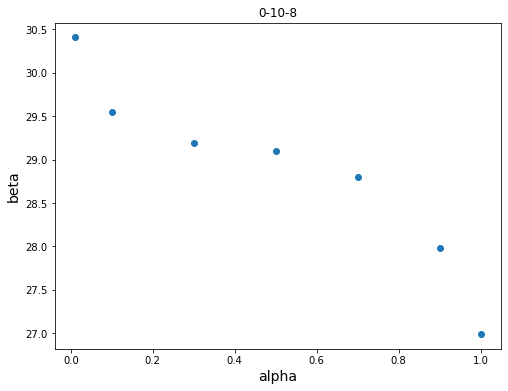

In [ ]:
for rew in list(Multinomial_Rewards2.keys()):
    fig, ax = plt.subplots(figsize = (8,6))
    ax.scatter([0.01, 0.1, 0.3, 0.5, 0.7, 0.9 , 1], mean_convg_time_alpha_4[rew])
    plt.xlabel("alpha",fontsize = 14)
    plt.ylabel("beta",fontsize = 14)
    plt.title(rew)
    plt.show()

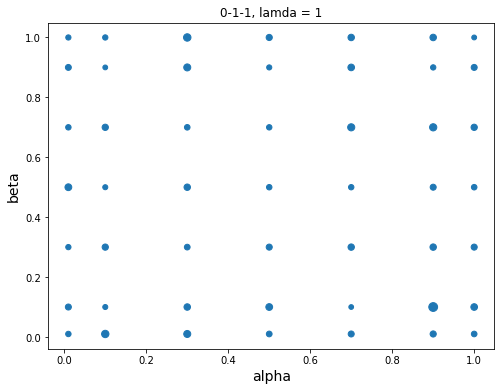

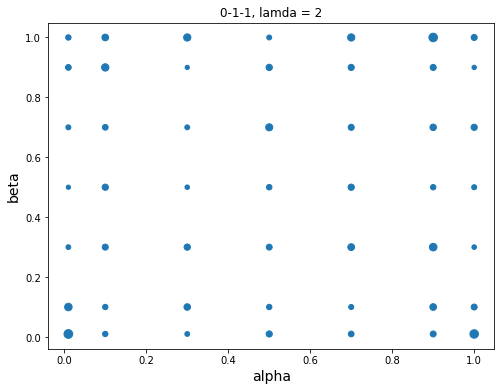

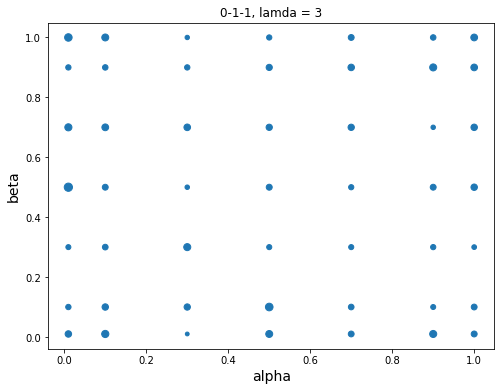

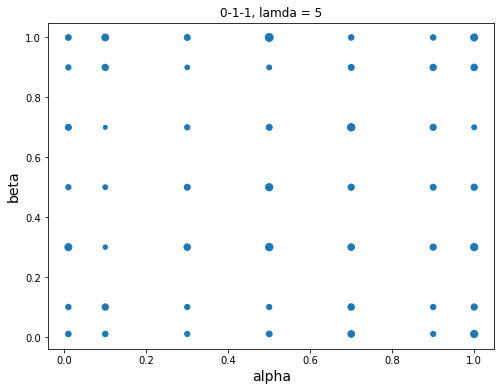

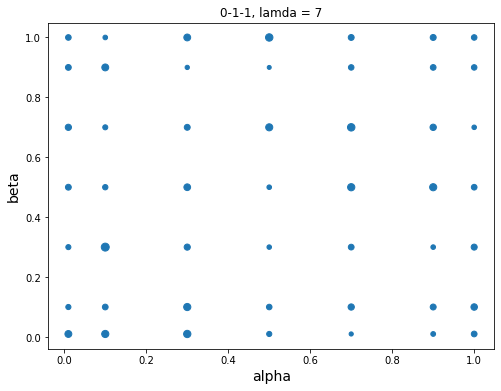

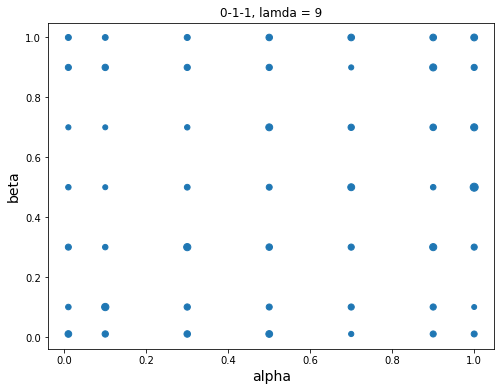

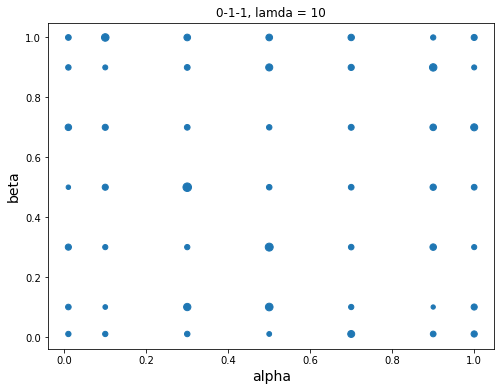

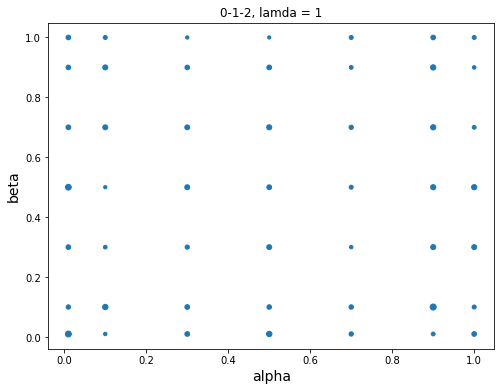

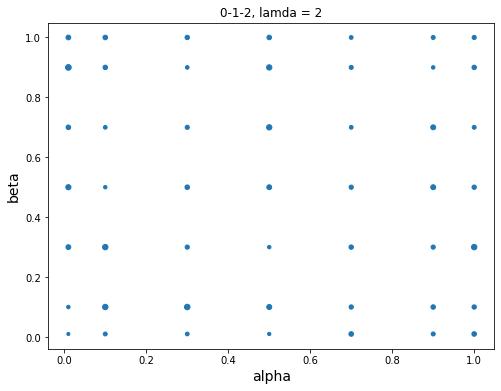

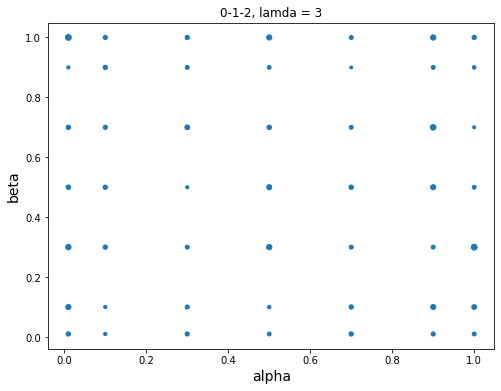

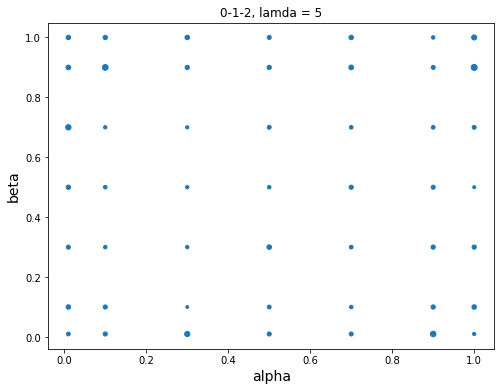

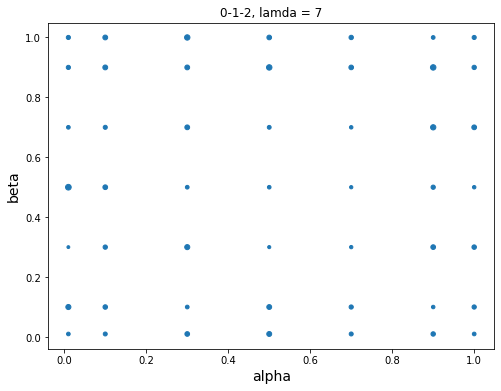

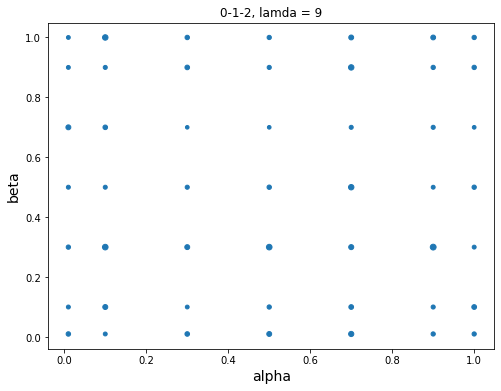

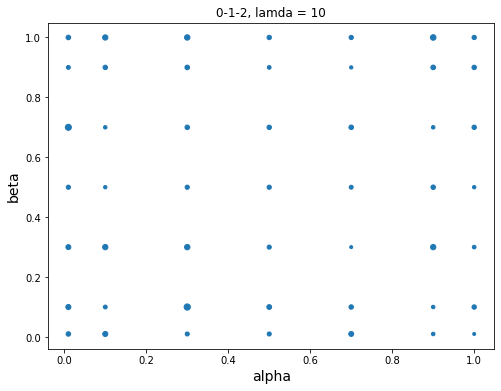

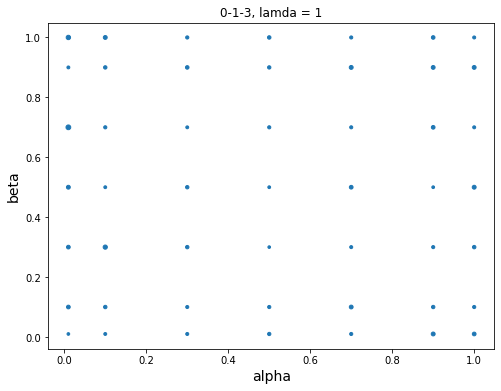

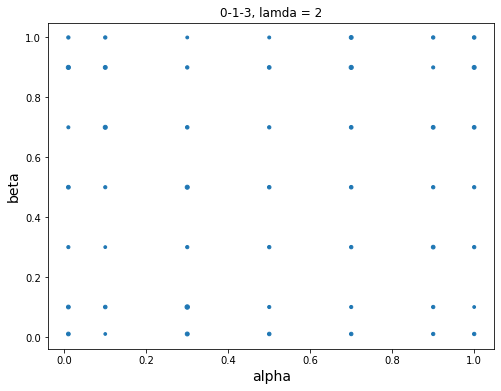

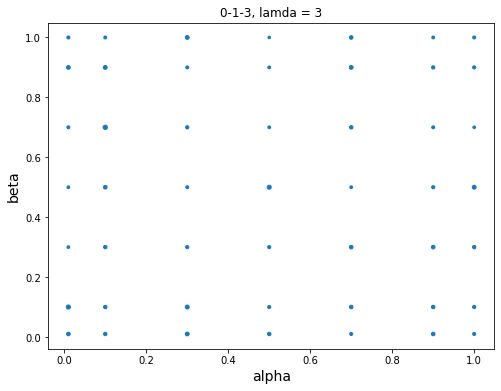

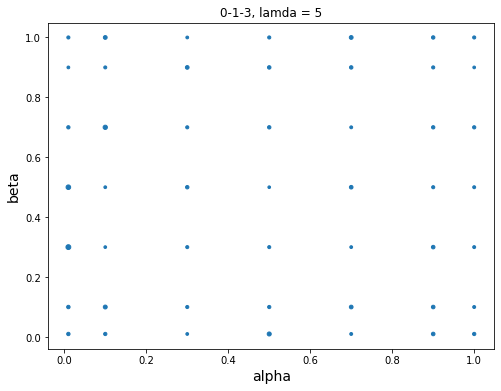

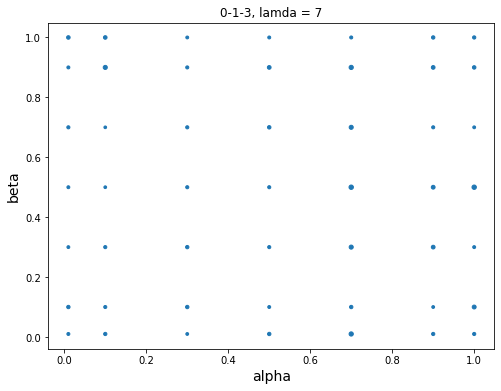

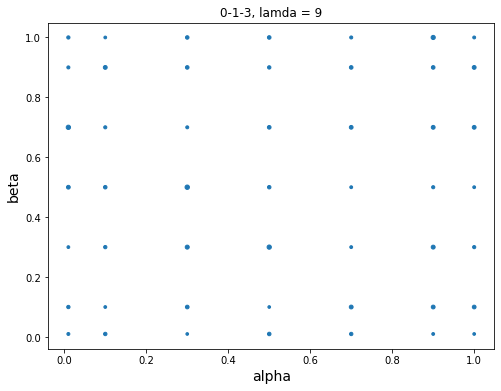

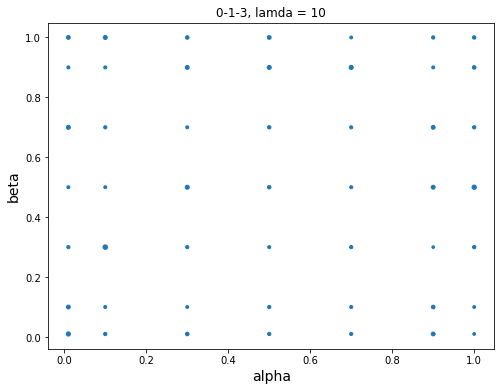

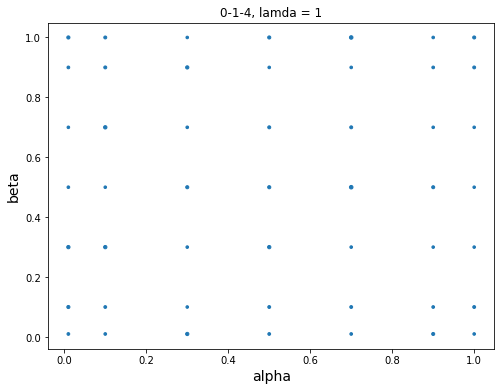

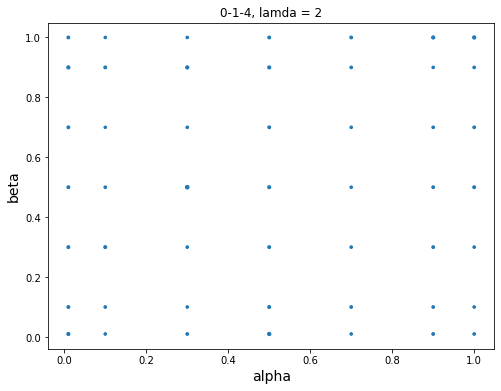

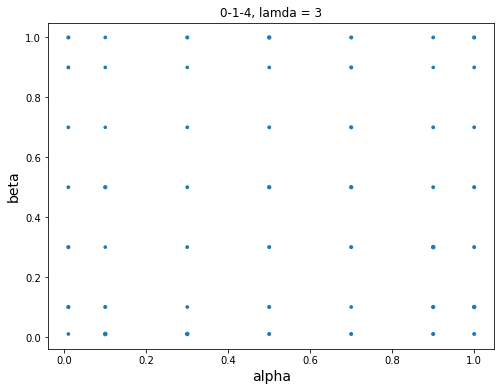

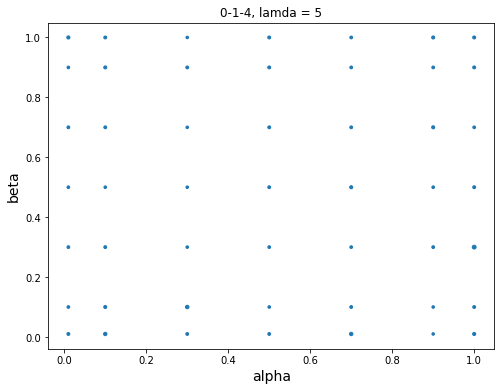

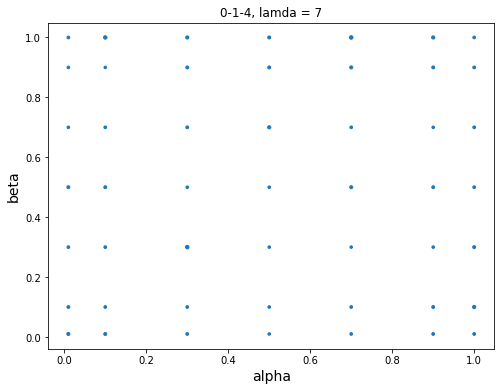

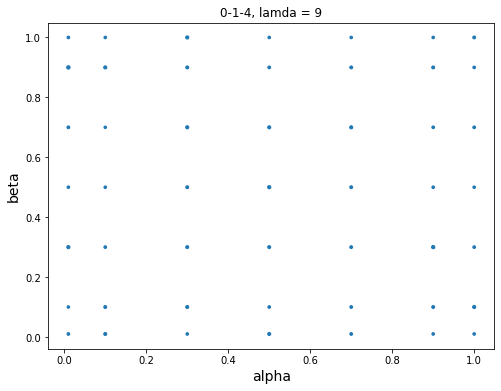

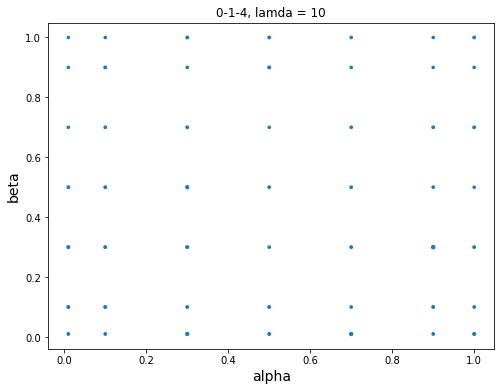

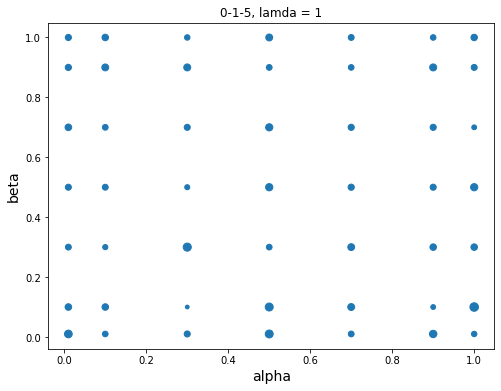

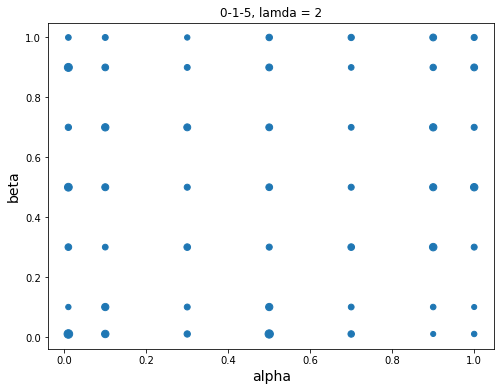

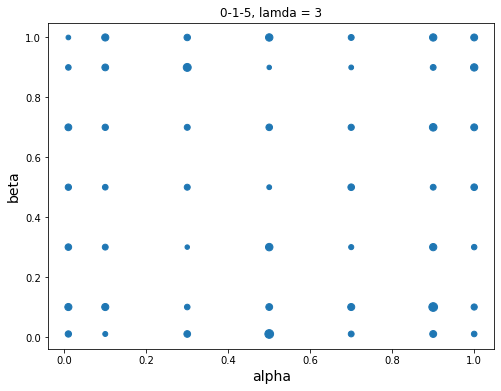

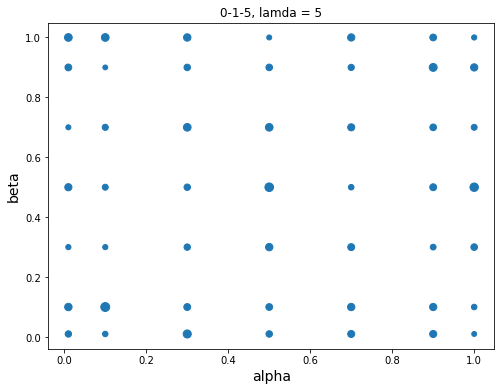

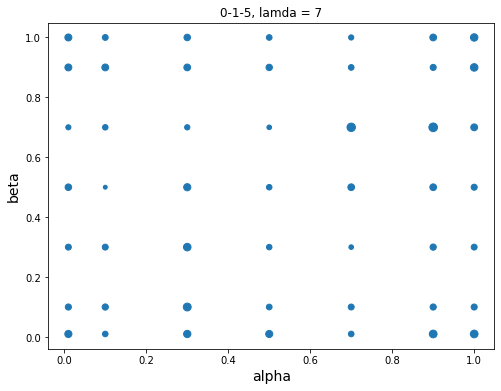

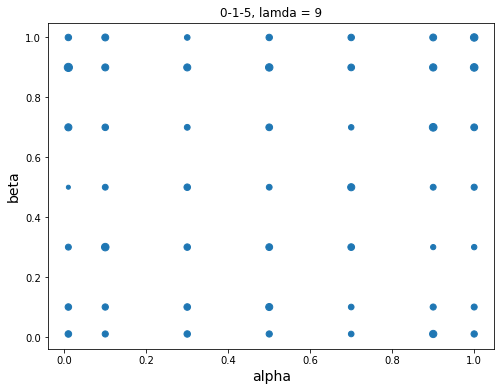

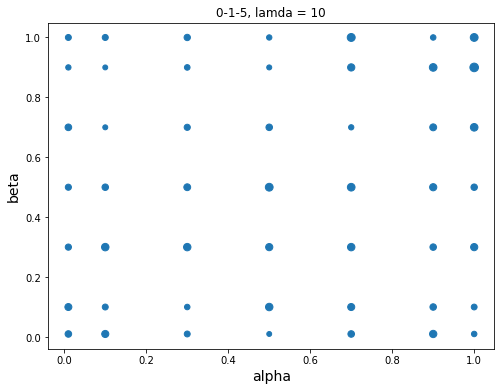

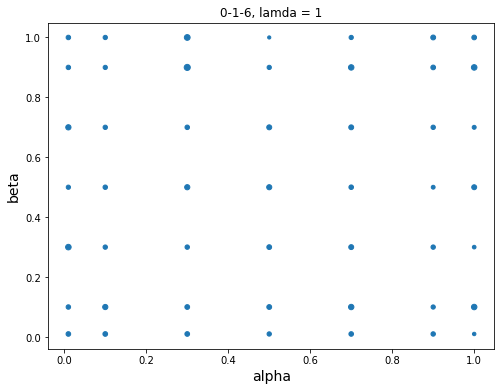

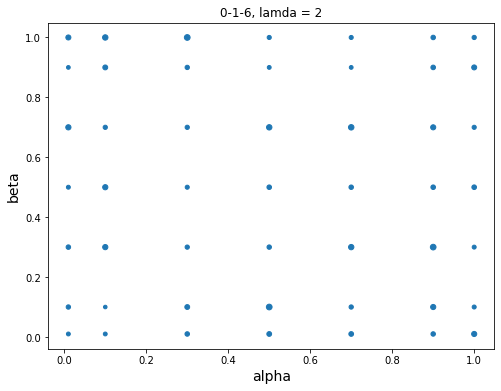

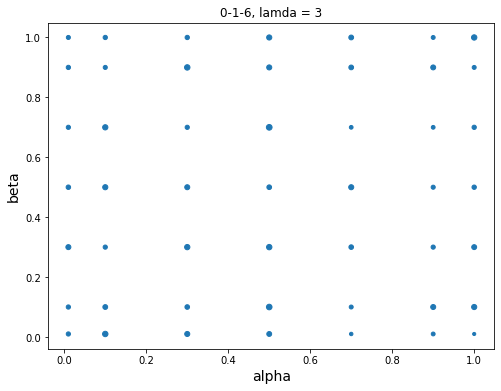

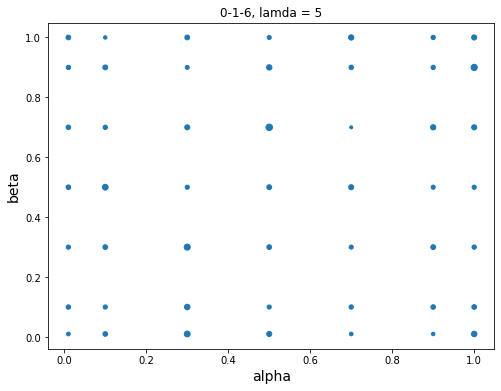

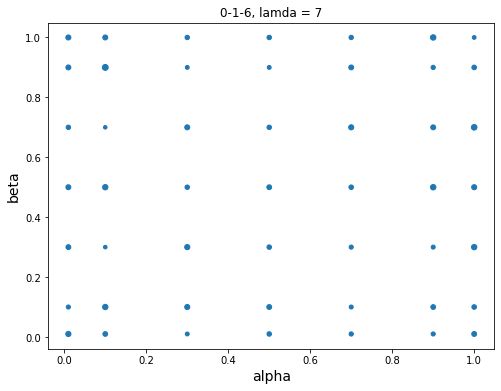

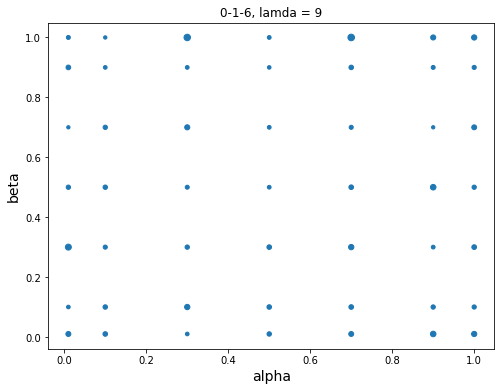

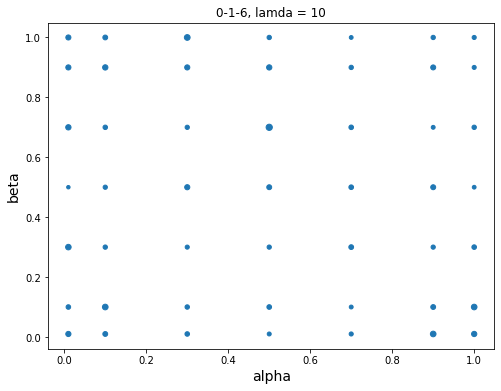

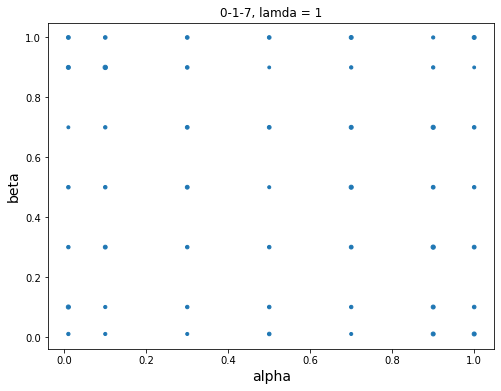

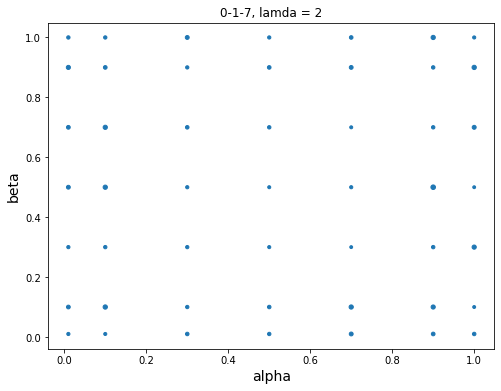

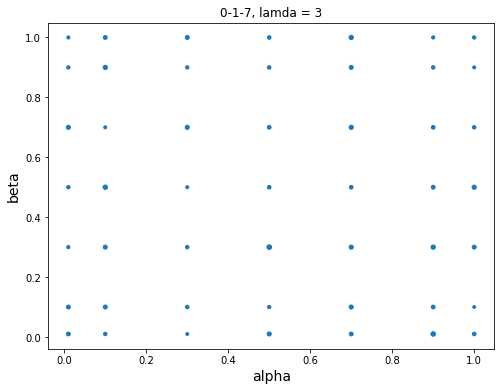

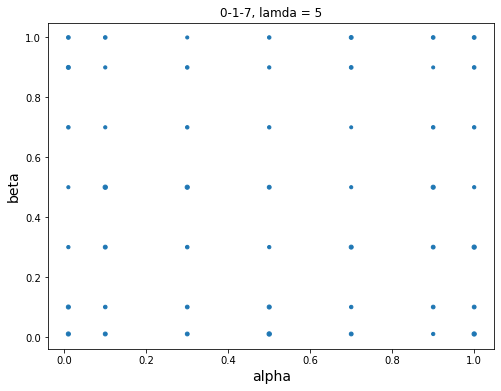

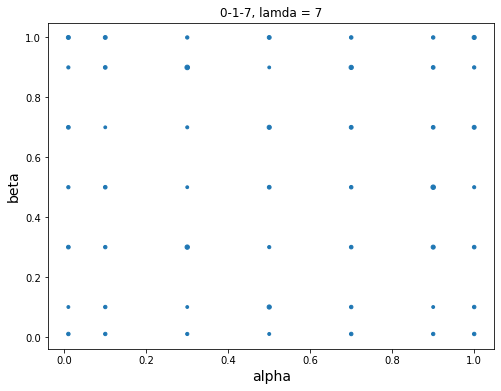

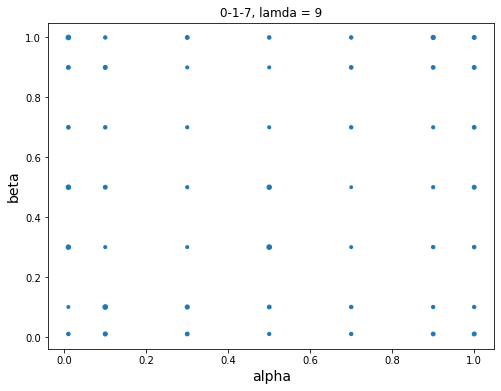

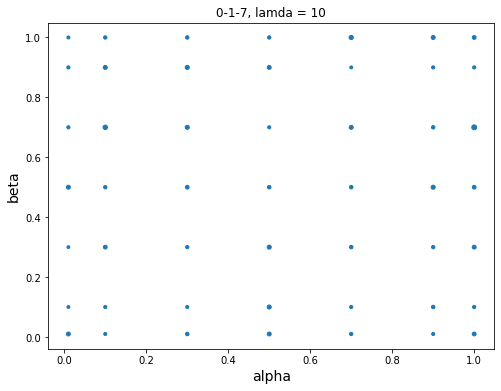

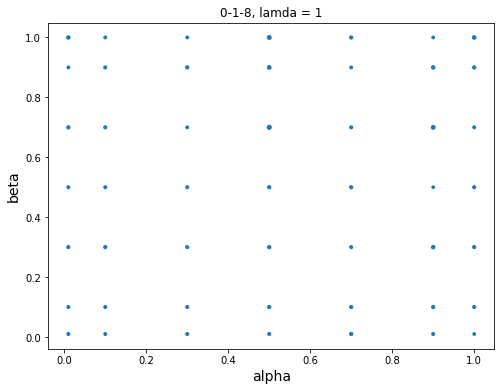

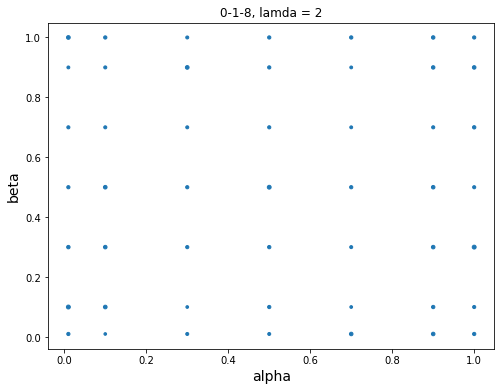

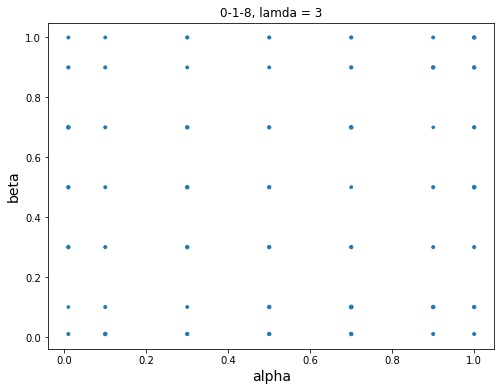

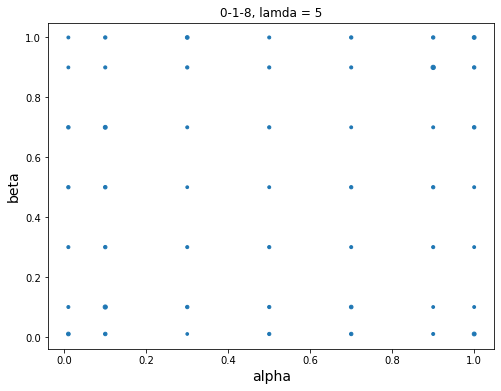

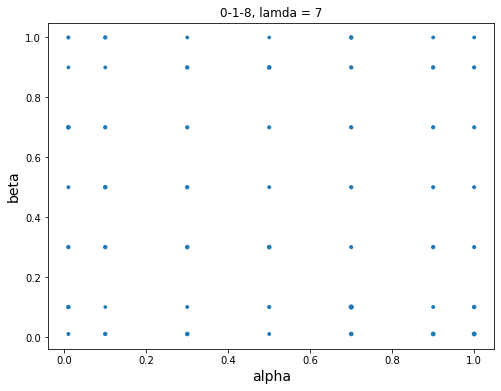

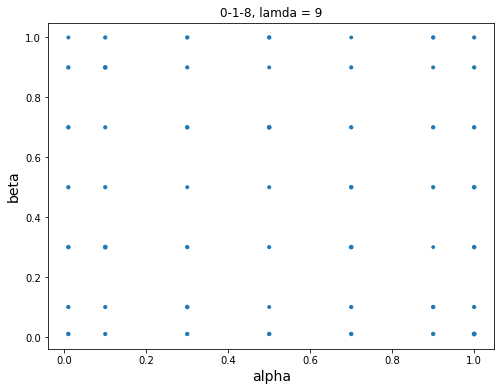

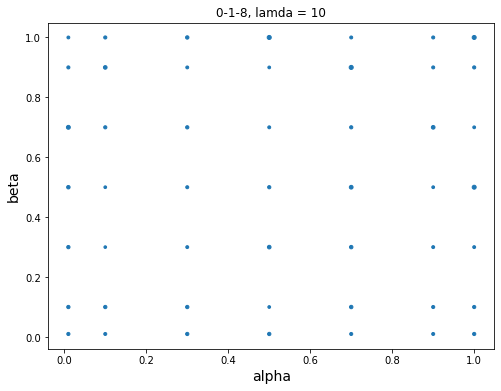

In [ ]:
for rew in list(Multinomial_Rewards1.keys()):
    for i,lamda in enumerate([1,2,3,5,7,9,10]):
        j = 2*i
        plot_scatter(Mult_pi_1_1[rew][j],Mult_pi_1_1[rew][j+1],Mult_pi_2_1[rew][j],Mult_pi_2_1[rew][j+1],Mult_pi_1_s_1[rew][i],Mult_pi_2_s_1[rew][i],rew,lamda)

In [ ]:
Multinomial_Rewards = {  '2pos_near1' : [MultinomialReward([1.2,1],[0.5,0.5]),MultinomialReward([1.1,0.9],[0.5,0.5])],
                         '2pos_near2' : [MultinomialReward([1.4,0.8],[0.5,0.5]),MultinomialReward([1.4,0.6],[0.5,0.5])],
                         '2pos_near3' : [MultinomialReward([1.6,0.6],[0.5,0.5]),MultinomialReward([1.4,0.6],[0.5,0.5])],
                         '2pos_near4' : [MultinomialReward([1.8,0.4],[0.5,0.5]),MultinomialReward([1.4,0.6],[0.5,0.5])],

                         'neg_pos_near1' : [MultinomialReward([0.2,0.0],[0.5,0.5]),MultinomialReward([0,-0.2],[0.5,0.5])],
                         'neg_pos_near2' : [MultinomialReward([0.3,-0.1],[0.5,0.5]),MultinomialReward([-0.05,-0.15],[0.5,0.5])],
                         'neg_pos_near3' : [MultinomialReward([0.4,-0.2],[0.5,0.5]),MultinomialReward([0,-0.2],[0.5,0.5])],
                         'neg_pos_near4' : [MultinomialReward([0.5,-0.3],[0.5,0.5]),MultinomialReward([0,-0.2],[0.5,0.5])],
                         'neg_pos_near5' : [MultinomialReward([0.5,-0.3],[0.5,0.5]),MultinomialReward([0.6,-0.2],[1/8,7/8])],
                         'neg_pos_near6' : [MultinomialReward([0.25,-0.05],[0.5,0.5]),MultinomialReward([0.9,-0.2],[1/11,10/11])],
                         'neg_pos_near7' : [MultinomialReward([0.95,-0.05],[0.15,0.85]),MultinomialReward([0,-0.2],[0.5,0.5])],
                       
                         'neg_pos_close1' : [MultinomialReward([1,-1],[0.8,0.2]),MultinomialReward([1,-1],[0.7,0.3])],
                         'neg_pos_close2' : [MultinomialReward([1,-1],[0.8,0.2]),MultinomialReward([1,-1],[0.5,0.5])],
                         'neg_pos_close3' : [MultinomialReward([1,-1],[0.8,0.2]),MultinomialReward([1,-1],[0.3,0.7])],
                      } 

idx_opt_act = 0 
UFs = {}
for i in [0.01, 0.1, 0.3, 0.5, 0.7, 0.9 , 1, 2]:
    for j in [0.01, 0.1, 0.3, 0.5, 0.7, 0.9 , 1, 2]:
        for k in [-2, -1, 0, 0.1,0.3,0.5,1,3,5,7,9,10]:
            UFs['a:'+str(i)+',b:'+str(j)+',l:'+str(k)] = [i,j,k]

UFs['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(20)] = [0.9,0.9,20]
UFs['a:'+str(0.01)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.01,0.01,2.25]
UFs['a:'+str(0.01)+',b:'+str(0.9)+',l:'+str(2.25)] = [0.01,0.9,2.25]
UFs['a:'+str(0.9)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.9,0.01,2.25]

#### Presentation 

##### zero initialization and average reward 

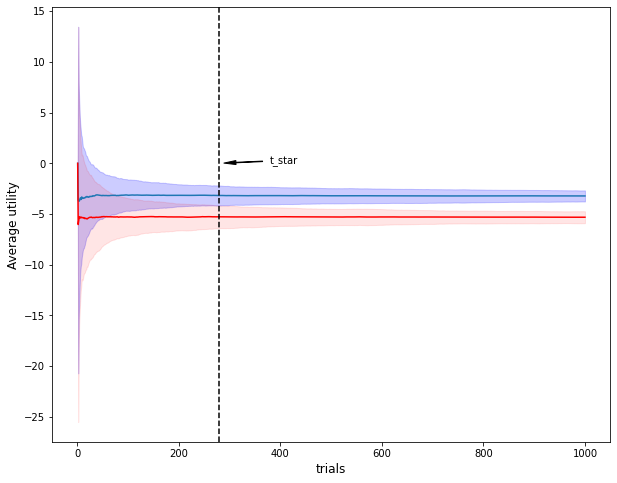

In [ ]:
uf_key = ['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(2.25)] 
uf = [0.9,0.9,20]
Rew_key = 'neg_pos_close1'
Rew = [MultinomialReward([1,-1],[0.8,0.2]),MultinomialReward([1,-1],[0.7,0.3])]

Q = np.zeros((len(Rew),200,1000))

for r in range(200):
    avg = [0] * len(Rew) 
    for t in range(1,1000):
        for k in range(len(Rew)):
            rew = Rew[k].get_reward()
            u = utility_function(rew,uf[0],uf[1],uf[2])
            avg[k] += (u - avg[k]) / t# alpha = cte 
            Q[k,r,t] = avg[k]

means = np.mean(Q,axis = 1)  
stds = np.std(Q,axis = 1, ddof = 1)
upper = means + 1.96 * stds
lower = means - 1.96 * stds

max_idx = np.argmax(means[:,-1])
times = np.where((np.amax(lower,axis = 0) > np.amax(np.delete(upper, (max_idx), axis=0),axis = 0 )).astype(int) == 0 )
t_star = times[0][-1] + 2

fig, ax = plt.subplots(figsize = (10,8))

ax.plot(list(range(1,1001)),means[0,:])
ax.fill_between(list(range(1,1001)), upper[0,:], lower[0,:], color='b', alpha=.2)

ax.plot(list(range(1,1001)),means[1,:],color = 'r')
ax.fill_between(list(range(1,1001)), upper[1,:], lower[1,:], color='r', alpha=.1)

plt.axvline(x= t_star, color='k', linestyle='--')
arrow_properties = dict(facecolor="black", width=0.5,headwidth=4, shrink=0.1)
plt.annotate("t_star", xy=(t_star, upper[0,0]),xytext=(t_star + 100, upper[0,0]),arrowprops=arrow_properties)

plt.xlabel("trials",fontsize = 12)
plt.ylabel("Average utility",fontsize = 12)
# plt.title()
plt.show()

In [ ]:
t_star

279

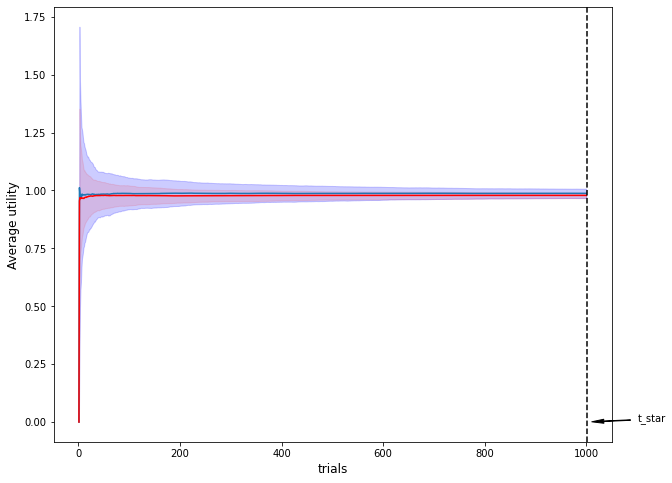

In [ ]:
uf_key = ['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(2.25)] 
uf = [0.5,0.5,9]
Rew_key = 'neg_pos_close1'
Rew = [MultinomialReward([1.8,0.4],[0.5,0.5]),MultinomialReward([1.4,0.6],[0.5,0.5])]

Q = np.zeros((len(Rew),200,1000))

for r in range(200):
    avg = [0] * len(Rew) 
    for t in range(1,1000):
        for k in range(len(Rew)):
            rew = Rew[k].get_reward()
            u = utility_function(rew,uf[0],uf[1],uf[2])
            avg[k] += (u - avg[k]) /t # alpha = cte 
            Q[k,r,t] = avg[k]

means = np.mean(Q,axis = 1)  
stds = np.std(Q,axis = 1, ddof = 1)
upper = means + 1.96 * stds
lower = means - 1.96 * stds

max_idx = np.argmax(means[:,-1])
times = np.where((np.amax(lower,axis = 0) > np.amax(np.delete(upper, (max_idx), axis=0),axis = 0 )).astype(int) == 0 )
t_star = times[0][-1] + 2

fig, ax = plt.subplots(figsize = (10,8))

ax.plot(list(range(1,1001)),means[0,:])
ax.fill_between(list(range(1,1001)), upper[0,:], lower[0,:], color='b', alpha=.2)

ax.plot(list(range(1,1001)),means[1,:],color = 'r')
ax.fill_between(list(range(1,1001)), upper[1,:], lower[1,:], color='r', alpha=.1)

plt.axvline(x= t_star, color='k', linestyle='--')
arrow_properties = dict(facecolor="black", width=0.5,headwidth=4, shrink=0.1)
plt.annotate("t_star", xy=(t_star, upper[0,0]),xytext=(t_star + 100, upper[0,0]),arrowprops=arrow_properties)

plt.xlabel("trials",fontsize = 12)
plt.ylabel("Average utility",fontsize = 12)
# plt.title()
plt.show()

In [ ]:
t_star

244

##### zero initialization and exponential moving average reward 

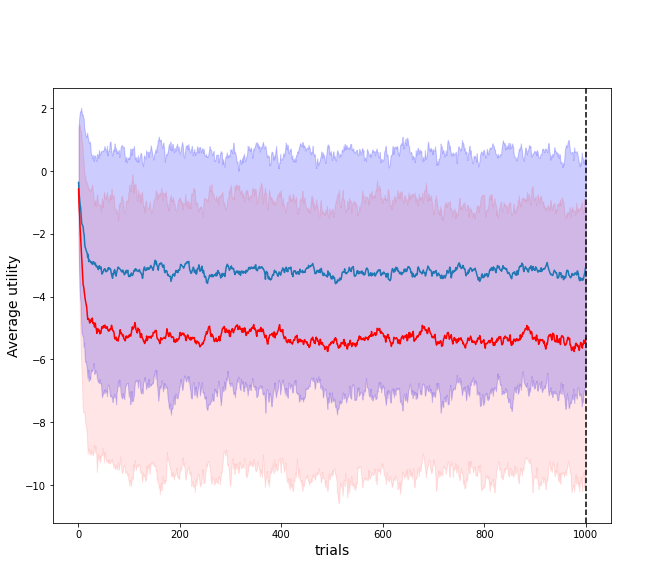

In [ ]:
uf_key = ['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(2.25)] 
uf = [0.9,0.9,20]
Rew_key = 'neg_pos_close1'
Rew = [MultinomialReward([1,-1],[0.8,0.2]),MultinomialReward([1,-1],[0.7,0.3])]

Q = np.zeros((len(Rew),200,1000))

for r in range(200):
    avg = [0] * len(Rew) 
    for t in range(1000):
        for k in range(len(Rew)):
            rew = Rew[k].get_reward()
            u = utility_function(rew,uf[0],uf[1],uf[2])
            avg[k] += (u - avg[k]) * 0.1# alpha = cte 
            Q[k,r,t] = avg[k]

means = np.mean(Q,axis = 1)  
stds = np.std(Q,axis = 1, ddof = 1)
upper = means + 1.96 * stds
lower = means - 1.96 * stds

max_idx = np.argmax(means[:,-1])
times = np.where((np.amax(lower,axis = 0) > np.amax(np.delete(upper, (max_idx), axis=0),axis = 0 )).astype(int) == 0 )
t_star = times[0][-1] + 2

fig, ax = plt.subplots(figsize = (10,8))
ax.plot(list(range(1,1001)),means[0,:])
ax.fill_between(list(range(1,1001)), upper[0,:], lower[0,:], color='b', alpha=.2)
ax.plot(list(range(1,1001)),means[1,:],color = 'r')
ax.fill_between(list(range(1,1001)), upper[1,:], lower[1,:], color='r', alpha=.1)
plt.axvline(x= t_star, color='k', linestyle='--')
arrow_properties = dict(facecolor="black", width=0.5,headwidth=4, shrink=0.1)
plt.annotate("t_star", xy=(t_star, 5),xytext=(t_star + 100, 5),arrowprops=arrow_properties)
plt.xlabel("trials",fontsize = 14)
plt.ylabel("Average utility",fontsize = 14)
# plt.title()
plt.show()

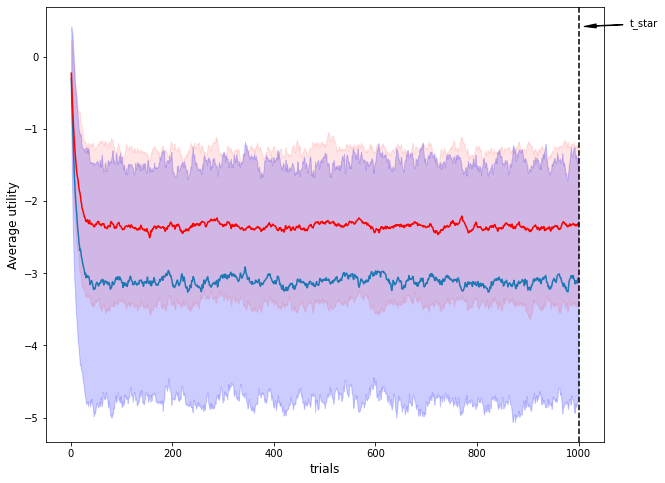

In [ ]:
uf_key = ['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(2.25)] 
uf = [0.9,0.9,20]
Rew_key = 'neg_pos_close1'
Rew = [MultinomialReward([0.5,-0.3],[0.5,0.5]),MultinomialReward([0,-0.2],[0.5,0.5])]

Q = np.zeros((len(Rew),200,1000))

for r in range(200):
    avg = [0] * len(Rew) 
    for t in range(1000):
        for k in range(len(Rew)):
            rew = Rew[k].get_reward()
            u = utility_function(rew,uf[0],uf[1],uf[2])
            avg[k] += (u - avg[k]) * 0.1# alpha = cte 
            Q[k,r,t] = avg[k]

means = np.mean(Q,axis = 1)  
stds = np.std(Q,axis = 1, ddof = 1)
upper = means + 1.96 * stds
lower = means - 1.96 * stds

max_idx = np.argmax(means[:,-1])
times = np.where((np.amax(lower,axis = 0) > np.amax(np.delete(upper, (max_idx), axis=0),axis = 0 )).astype(int) == 0 )
t_star = times[0][-1] + 2

fig, ax = plt.subplots(figsize = (10,8))

ax.plot(list(range(1,1001)),means[0,:])
ax.fill_between(list(range(1,1001)), upper[0,:], lower[0,:], color='b', alpha=.2)

ax.plot(list(range(1,1001)),means[1,:],color = 'r')
ax.fill_between(list(range(1,1001)), upper[1,:], lower[1,:], color='r', alpha=.1)

plt.axvline(x= t_star, color='k', linestyle='--')
arrow_properties = dict(facecolor="black", width=0.5,headwidth=4, shrink=0.1)
plt.annotate("t_star", xy=(t_star, upper[0,0]),xytext=(t_star + 100, upper[0,0]),arrowprops=arrow_properties)

plt.xlabel("trials",fontsize = 12)
plt.ylabel("Average utility",fontsize = 12)
# plt.title()
plt.show()

#### average utility and zero initialization 

In [ ]:
Mult_Convg_trials = {}
Mult_policy = {}

for j in tqdm(range(len(Multinomial_Rewards))): 
    Rew = list(Multinomial_Rewards.values())[j]
    Mult_Convg_trials[list(Multinomial_Rewards.keys())[j]] = {}
    Mult_policy[list(Multinomial_Rewards.keys())[j]] = {}

    for i in range(len(UFs)):
        Q = np.zeros((len(Rew),50,600))
        for r in range(50):
            avg = [0] * len(Rew) 
            uf = list(UFs.values())[i]
            for t in range(1,600):
                for k in range(len(Rew)):
                    rew = Rew[k].get_reward()
                    u = utility_function(rew,uf[0],uf[1],uf[2])
                    avg[k] += (u - avg[k]) / t # alpha = cte 
                    Q[k,r,t] = avg[k]

        means = np.mean(Q,axis = 1)  
        stds = np.std(Q,axis = 1, ddof = 1)
        upper = means + 1.96 * stds
        lower = means - 1.96 * stds

        max_idx = np.argmax(means[:,-1])
        times = np.where((np.amax(lower,axis = 0) > np.amax(np.delete(upper, (max_idx), axis=0),axis = 0 )).astype(int) == 0 )
        t_star = times[0][-1] + 2

        Mult_Convg_trials[list(Multinomial_Rewards.keys())[j]][list(UFs.keys())[i]] = t_star
 
        if means[idx_opt_act,:][-1] > np.amax(np.delete(upper, (idx_opt_act), axis=0),axis = 0 )[-1]:
            Mult_policy[list(Multinomial_Rewards.keys())[j]][list(UFs.keys())[i]] = 1
        else :
            Mult_policy[list(Multinomial_Rewards.keys())[j]][list(UFs.keys())[i]] = 0

100%|██████████| 14/14 [38:41<00:00, 165.84s/it]


In [ ]:
Mult_Convg_trials

{'2pos_near1': {'a:0.01,b:0.01,l:-1': 9,
  'a:0.01,b:0.01,l:-2': 16,
  'a:0.01,b:0.01,l:0': 18,
  'a:0.01,b:0.01,l:0.1': 14,
  'a:0.01,b:0.01,l:0.3': 22,
  'a:0.01,b:0.01,l:0.5': 10,
  'a:0.01,b:0.01,l:1': 10,
  'a:0.01,b:0.01,l:10': 12,
  'a:0.01,b:0.01,l:2.25': 23,
  'a:0.01,b:0.01,l:3': 12,
  'a:0.01,b:0.01,l:5': 16,
  'a:0.01,b:0.01,l:7': 11,
  'a:0.01,b:0.01,l:9': 13,
  'a:0.01,b:0.1,l:-1': 17,
  'a:0.01,b:0.1,l:-2': 20,
  'a:0.01,b:0.1,l:0': 33,
  'a:0.01,b:0.1,l:0.1': 30,
  'a:0.01,b:0.1,l:0.3': 16,
  'a:0.01,b:0.1,l:0.5': 18,
  'a:0.01,b:0.1,l:1': 13,
  'a:0.01,b:0.1,l:10': 14,
  'a:0.01,b:0.1,l:3': 12,
  'a:0.01,b:0.1,l:5': 21,
  'a:0.01,b:0.1,l:7': 26,
  'a:0.01,b:0.1,l:9': 15,
  'a:0.01,b:0.3,l:-1': 19,
  'a:0.01,b:0.3,l:-2': 11,
  'a:0.01,b:0.3,l:0': 24,
  'a:0.01,b:0.3,l:0.1': 9,
  'a:0.01,b:0.3,l:0.3': 16,
  'a:0.01,b:0.3,l:0.5': 24,
  'a:0.01,b:0.3,l:1': 19,
  'a:0.01,b:0.3,l:10': 16,
  'a:0.01,b:0.3,l:3': 13,
  'a:0.01,b:0.3,l:5': 20,
  'a:0.01,b:0.3,l:7': 10,
  'a:0.01

In [ ]:
Mult_policy

{'2pos_near1': {'a:0.01,b:0.01,l:-1': 1,
  'a:0.01,b:0.01,l:-2': 1,
  'a:0.01,b:0.01,l:0': 1,
  'a:0.01,b:0.01,l:0.1': 1,
  'a:0.01,b:0.01,l:0.3': 1,
  'a:0.01,b:0.01,l:0.5': 1,
  'a:0.01,b:0.01,l:1': 1,
  'a:0.01,b:0.01,l:10': 1,
  'a:0.01,b:0.01,l:2.25': 1,
  'a:0.01,b:0.01,l:3': 1,
  'a:0.01,b:0.01,l:5': 1,
  'a:0.01,b:0.01,l:7': 1,
  'a:0.01,b:0.01,l:9': 1,
  'a:0.01,b:0.1,l:-1': 1,
  'a:0.01,b:0.1,l:-2': 1,
  'a:0.01,b:0.1,l:0': 1,
  'a:0.01,b:0.1,l:0.1': 1,
  'a:0.01,b:0.1,l:0.3': 1,
  'a:0.01,b:0.1,l:0.5': 1,
  'a:0.01,b:0.1,l:1': 1,
  'a:0.01,b:0.1,l:10': 1,
  'a:0.01,b:0.1,l:3': 1,
  'a:0.01,b:0.1,l:5': 1,
  'a:0.01,b:0.1,l:7': 1,
  'a:0.01,b:0.1,l:9': 1,
  'a:0.01,b:0.3,l:-1': 1,
  'a:0.01,b:0.3,l:-2': 1,
  'a:0.01,b:0.3,l:0': 1,
  'a:0.01,b:0.3,l:0.1': 1,
  'a:0.01,b:0.3,l:0.3': 1,
  'a:0.01,b:0.3,l:0.5': 1,
  'a:0.01,b:0.3,l:1': 1,
  'a:0.01,b:0.3,l:10': 1,
  'a:0.01,b:0.3,l:3': 1,
  'a:0.01,b:0.3,l:5': 1,
  'a:0.01,b:0.3,l:7': 1,
  'a:0.01,b:0.3,l:9': 1,
  'a:0.01,b:0.5,l:

In [ ]:
Mult_Convg_trials_file = open('/content/drive/My Drive/Mult_Convg_trials.csv', "w")

writer = csv.writer(Mult_Convg_trials_file)
for key, value in Mult_Convg_trials.items():
    writer.writerow([key, value])

Mult_Convg_trials_file.close()

In [ ]:
Mult_policy_file = open('/content/drive/My Drive/Mult_policy.csv', "w")

writer = csv.writer(Mult_policy_file)
for key, value in Mult_policy.items():
    writer.writerow([key, value])

Mult_policy_file.close()

In [ ]:
with open('/content/drive/My Drive/Mult_Convg_trials.csv', mode='r') as infile:
    reader = csv.reader(infile)
    my_dict = {rows[0]:rows[1] for rows in reader}
Mult_Convg_trials = {}
for key, value in my_dict.items():
    json_acceptable_string = value.replace("'", "\"")
    Mult_Convg_trials[key] = json.loads(json_acceptable_string)

In [ ]:
with open('/content/drive/My Drive/Mult_policy.csv', mode='r') as infile:
    reader = csv.reader(infile)
    my_dict = {rows[0]:rows[1] for rows in reader}

Mult_policy = {}
for key, value in my_dict.items():
    json_acceptable_string = value.replace("'", "\"")
    Mult_policy[key] = json.loads(json_acceptable_string)

In [ ]:
Mult_pi_1 = {} 
Mult_pi_2 = {} 
for rew in ['2pos_near1','2pos_near4','neg_pos_near1','neg_pos_near4','neg_pos_near7']:
     pi_1 = get_policies(Mult_policy[rew], 1)
     pi_2 = get_policies(Mult_policy[rew], 0)
     
     pi_1_half_a = [item[0] for item in pi_1 if item[2] == 0.5]
     pi_1_half_b = [item[1] for item in pi_1 if item[2] == 0.5]
     pi_2_half_a = [item[0] for item in pi_2 if item[2] == 0.5]
     pi_2_half_b = [item[1] for item in pi_2 if item[2] == 0.5]     
     pi_1_3_a = [item[0] for item in pi_1 if item[2] == 3]
     pi_1_3_b = [item[1] for item in pi_1 if item[2] == 3]
     pi_2_3_a = [item[0] for item in pi_2 if item[2] == 3]
     pi_2_3_b = [item[1] for item in pi_2 if item[2] == 3]  
     pi_1_7_a = [item[0] for item in pi_1 if item[2] == 7]
     pi_1_7_b = [item[1] for item in pi_1 if item[2] == 7]
     pi_2_7_a = [item[0] for item in pi_2 if item[2] == 7]
     pi_2_7_b = [item[1] for item in pi_2 if item[2] == 7]  

     Mult_pi_1[rew] = [pi_1_half_a,pi_1_half_b,pi_1_3_a,pi_1_3_b,pi_1_7_a,pi_1_7_b]
    
     Mult_pi_2[rew] = [pi_2_half_a,pi_2_half_b,pi_2_3_a,pi_2_3_b,pi_2_7_a,pi_2_7_b]

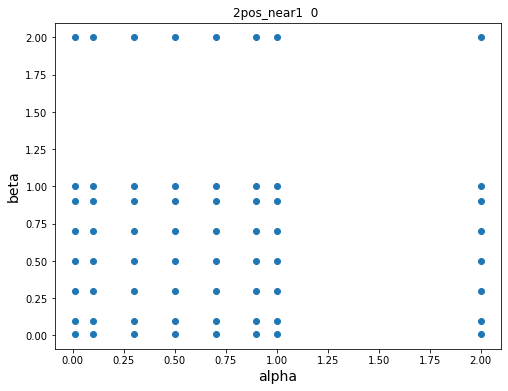

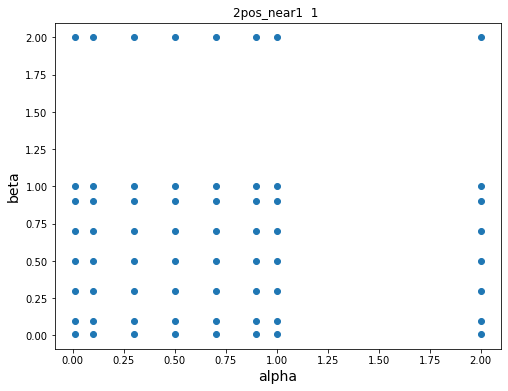

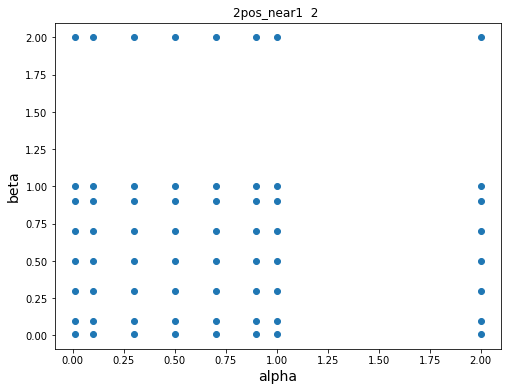

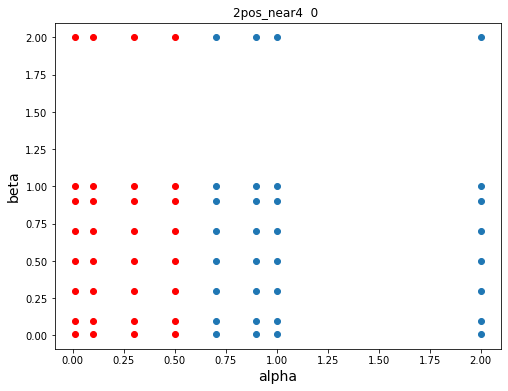

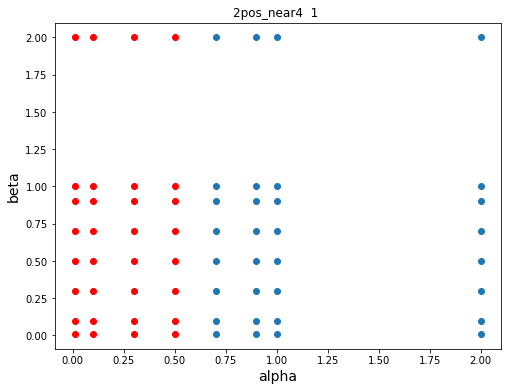

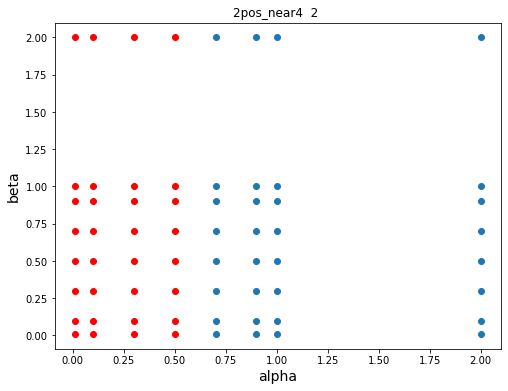

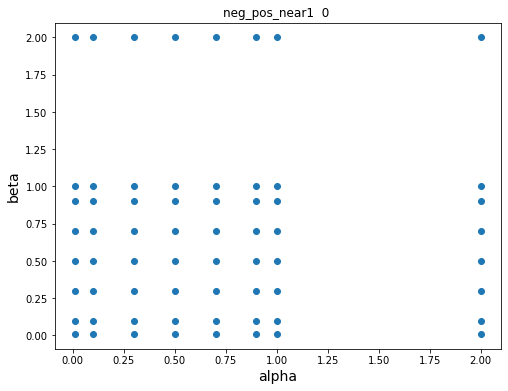

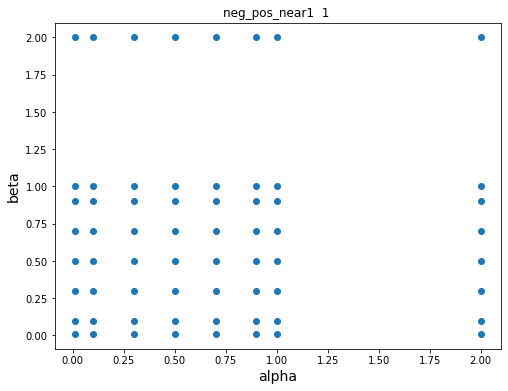

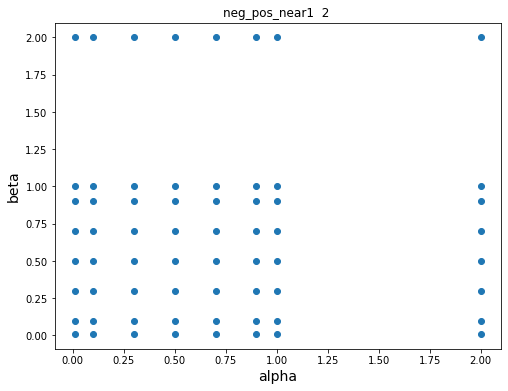

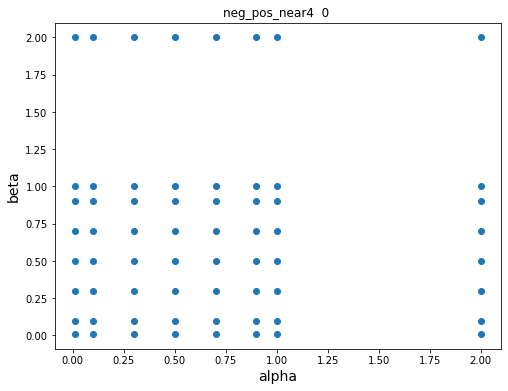

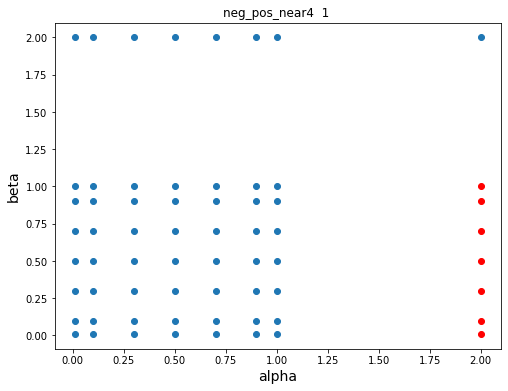

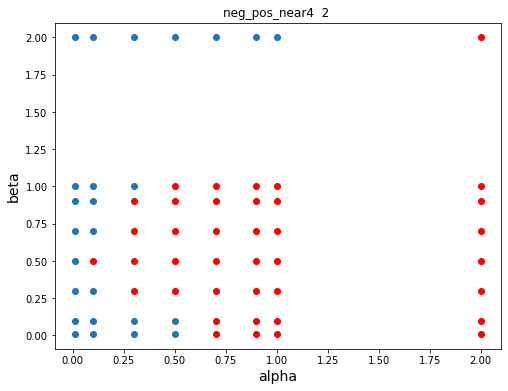

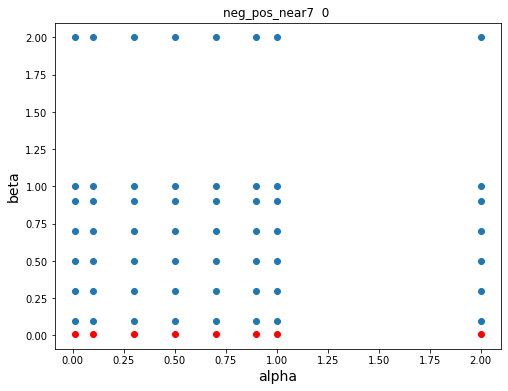

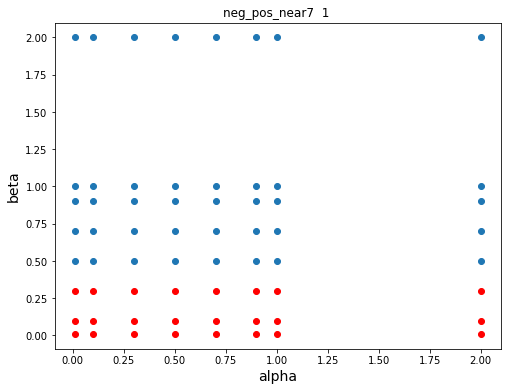

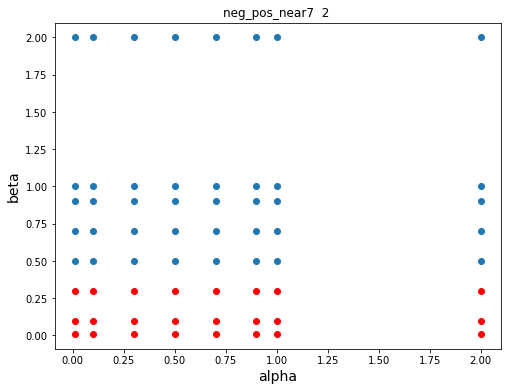

In [ ]:
for rew in ['2pos_near1','2pos_near4','neg_pos_near1','neg_pos_near4','neg_pos_near7']:
    fig, ax = plt.subplots(figsize = (8,6))
    ax.scatter(Mult_pi_1[rew][0],Mult_pi_1[rew][1])
    ax.scatter(Mult_pi_2[rew][0],Mult_pi_2[rew][1],color = 'r')

    plt.xlabel("alpha",fontsize = 14)
    plt.ylabel("beta",fontsize = 14)
    plt.title(rew + "  0 ")
    plt.show()

    fig, ax = plt.subplots(figsize = (8,6))
    ax.scatter(Mult_pi_1[rew][2],Mult_pi_1[rew][3])
    ax.scatter(Mult_pi_2[rew][2],Mult_pi_2[rew][3],color = 'r')

    plt.xlabel("alpha",fontsize = 14)
    plt.ylabel("beta",fontsize = 14)
    plt.title(rew + "  1 ")
    plt.show()

    fig, ax = plt.subplots(figsize = (8,6))
    ax.scatter(Mult_pi_1[rew][4],Mult_pi_1[rew][5])
    ax.scatter(Mult_pi_2[rew][4],Mult_pi_2[rew][5],color = 'r')

    plt.xlabel("alpha",fontsize = 14)
    plt.ylabel("beta",fontsize = 14)
    plt.title(rew + "  2 ")
    plt.show()

In [ ]:
Mult_Convg_trials_best = {} 
Mult_Convg_trials_worst = {} 
Mult_pi_1 = {} 
Mult_pi_2 = {} 

for j in range(len(Multinomial_Rewards)):
     rew = list(Multinomial_Rewards.keys())[j]
     ufs = sorted(Mult_Convg_trials[rew], key=Mult_Convg_trials[rew].get)
     best10_ufs = ufs[0:10]
     worst10_ufs = ufs[-10:]

     Mult_Convg_trials_best[rew] = {}
     Mult_Convg_trials_worst[rew] = {}
     Mult_pi_1[rew] = get_policies(Mult_policy[rew], 1)
     Mult_pi_2[rew] = get_policies(Mult_policy[rew], 0)
     
     for i in range(10):
         Mult_Convg_trials_best[rew][best10_ufs[i]] = Mult_Convg_trials[rew][best10_ufs[i]], Mult_policy[rew][best10_ufs[i]]
         Mult_Convg_trials_worst[rew][worst10_ufs[i]] = Mult_Convg_trials[rew][worst10_ufs[i]], Mult_policy[rew][worst10_ufs[i]]
         

In [ ]:
Mult_Convg_trials_best

{'2pos_near1': {'a:0.01,b:0.3,l:0.1': (12, 1),
  'a:0.01,b:0.3,l:7': (12, 1),
  'a:0.01,b:0.5,l:-1': (12, 1),
  'a:0.1,b:0.3,l:1': (10, 1),
  'a:0.7,b:0.7,l:10': (11, 1),
  'a:0.7,b:0.9,l:3': (11, 1),
  'a:0.9,b:0.1,l:-1': (11, 1),
  'a:1,b:0.1,l:3': (11, 1),
  'a:1,b:0.3,l:1': (11, 1),
  'a:1,b:0.3,l:3': (11, 1)},
 '2pos_near2': {'a:0.01,b:0.01,l:-1': (57, 1),
  'a:0.01,b:0.01,l:0.3': (72, 1),
  'a:0.01,b:0.01,l:5': (63, 1),
  'a:0.01,b:0.5,l:-2': (72, 1),
  'a:0.01,b:0.5,l:7': (71, 1),
  'a:0.1,b:0.1,l:7': (72, 1),
  'a:0.1,b:0.7,l:-2': (70, 1),
  'a:0.1,b:1,l:1': (68, 1),
  'a:0.1,b:2,l:-2': (71, 1),
  'a:0.3,b:0.3,l:3': (68, 1)},
 '2pos_near3': {'a:2,b:0.01,l:1': (122, 1),
  'a:2,b:0.01,l:7': (120, 1),
  'a:2,b:0.1,l:5': (100, 1),
  'a:2,b:0.3,l:0.3': (120, 1),
  'a:2,b:0.3,l:10': (120, 1),
  'a:2,b:0.5,l:-2': (116, 1),
  'a:2,b:0.5,l:0.5': (122, 1),
  'a:2,b:0.5,l:9': (112, 1),
  'a:2,b:2,l:1': (106, 1),
  'a:2,b:2,l:5': (99, 1)},
 '2pos_near4': {'a:2,b:0.01,l:0.1': (51, 1),
  'a:

In [ ]:
Mult_Convg_trials_worst

{'2pos_near1': {'a:0.01,b:0.7,l:7': (23, 1),
  'a:0.01,b:0.9,l:2.25': (26, 1),
  'a:0.1,b:0.3,l:5': (23, 1),
  'a:0.3,b:0.5,l:3': (24, 1),
  'a:0.3,b:0.7,l:9': (23, 1),
  'a:0.5,b:0.9,l:3': (23, 1),
  'a:1,b:0.7,l:0.5': (24, 1),
  'a:2,b:0.5,l:-1': (23, 1),
  'a:2,b:0.7,l:3': (23, 1),
  'a:2,b:1,l:0.3': (23, 1)},
 '2pos_near2': {'a:2,b:0.01,l:-1': (518, 1),
  'a:2,b:0.01,l:9': (601, 1),
  'a:2,b:0.5,l:0.1': (601, 1),
  'a:2,b:0.9,l:-1': (551, 1),
  'a:2,b:0.9,l:1': (601, 1),
  'a:2,b:1,l:0.1': (563, 1),
  'a:2,b:1,l:0.3': (522, 1),
  'a:2,b:1,l:0.5': (576, 1),
  'a:2,b:1,l:10': (601, 1),
  'a:2,b:2,l:10': (522, 1)},
 '2pos_near3': {'a:0.01,b:0.01,l:2.25': (601, 1),
  'a:0.01,b:0.9,l:2.25': (601, 1),
  'a:0.3,b:1,l:3': (601, 1),
  'a:0.3,b:1,l:7': (601, 1),
  'a:0.3,b:2,l:-2': (601, 1),
  'a:0.3,b:2,l:0.1': (601, 1),
  'a:0.3,b:2,l:5': (601, 1),
  'a:0.5,b:0.01,l:7': (601, 1),
  'a:0.5,b:0.1,l:10': (601, 1),
  'a:0.5,b:2,l:5': (601, 1)},
 '2pos_near4': {'a:0.01,b:0.01,l:2.25': (601, 0),

In [ ]:
Mult_pi_1

{'2pos_near1': [(0.01, 0.01, -2.0),
  (0.01, 0.01, -1.0),
  (0.01, 0.01, 0.0),
  (0.01, 0.01, 0.1),
  (0.01, 0.01, 0.3),
  (0.01, 0.01, 0.5),
  (0.01, 0.01, 1.0),
  (0.01, 0.01, 3.0),
  (0.01, 0.01, 5.0),
  (0.01, 0.01, 7.0),
  (0.01, 0.01, 9.0),
  (0.01, 0.01, 10.0),
  (0.01, 0.1, -2.0),
  (0.01, 0.1, -1.0),
  (0.01, 0.1, 0.0),
  (0.01, 0.1, 0.1),
  (0.01, 0.1, 0.3),
  (0.01, 0.1, 0.5),
  (0.01, 0.1, 1.0),
  (0.01, 0.1, 3.0),
  (0.01, 0.1, 5.0),
  (0.01, 0.1, 7.0),
  (0.01, 0.1, 9.0),
  (0.01, 0.1, 10.0),
  (0.01, 0.3, -2.0),
  (0.01, 0.3, -1.0),
  (0.01, 0.3, 0.0),
  (0.01, 0.3, 0.1),
  (0.01, 0.3, 0.3),
  (0.01, 0.3, 0.5),
  (0.01, 0.3, 1.0),
  (0.01, 0.3, 3.0),
  (0.01, 0.3, 5.0),
  (0.01, 0.3, 7.0),
  (0.01, 0.3, 9.0),
  (0.01, 0.3, 10.0),
  (0.01, 0.5, -2.0),
  (0.01, 0.5, -1.0),
  (0.01, 0.5, 0.0),
  (0.01, 0.5, 0.1),
  (0.01, 0.5, 0.3),
  (0.01, 0.5, 0.5),
  (0.01, 0.5, 1.0),
  (0.01, 0.5, 3.0),
  (0.01, 0.5, 5.0),
  (0.01, 0.5, 7.0),
  (0.01, 0.5, 9.0),
  (0.01, 0.5, 10.0),
  

In [ ]:
Mult_pi_2

{'2pos_near1': [],
 '2pos_near2': [],
 '2pos_near3': [],
 '2pos_near4': [(0.01, 0.01, -2.0),
  (0.01, 0.01, -1.0),
  (0.01, 0.01, 0.0),
  (0.01, 0.01, 0.1),
  (0.01, 0.01, 0.3),
  (0.01, 0.01, 0.5),
  (0.01, 0.01, 1.0),
  (0.01, 0.01, 3.0),
  (0.01, 0.01, 5.0),
  (0.01, 0.01, 7.0),
  (0.01, 0.01, 9.0),
  (0.01, 0.01, 10.0),
  (0.01, 0.1, -2.0),
  (0.01, 0.1, -1.0),
  (0.01, 0.1, 0.0),
  (0.01, 0.1, 0.1),
  (0.01, 0.1, 0.3),
  (0.01, 0.1, 0.5),
  (0.01, 0.1, 1.0),
  (0.01, 0.1, 3.0),
  (0.01, 0.1, 5.0),
  (0.01, 0.1, 7.0),
  (0.01, 0.1, 9.0),
  (0.01, 0.1, 10.0),
  (0.01, 0.3, -2.0),
  (0.01, 0.3, -1.0),
  (0.01, 0.3, 0.0),
  (0.01, 0.3, 0.1),
  (0.01, 0.3, 0.3),
  (0.01, 0.3, 0.5),
  (0.01, 0.3, 1.0),
  (0.01, 0.3, 3.0),
  (0.01, 0.3, 5.0),
  (0.01, 0.3, 7.0),
  (0.01, 0.3, 9.0),
  (0.01, 0.3, 10.0),
  (0.01, 0.5, -2.0),
  (0.01, 0.5, -1.0),
  (0.01, 0.5, 0.0),
  (0.01, 0.5, 0.1),
  (0.01, 0.5, 0.3),
  (0.01, 0.5, 0.5),
  (0.01, 0.5, 1.0),
  (0.01, 0.5, 3.0),
  (0.01, 0.5, 5.0),
  (0.0

### Normal Rewards

In [ ]:
Normal_Rewards = {  
                    '2pos_0.5_0.5' : [GaussianReward(1.1,0.2),GaussianReward(1,0.2)],
                    '2pos_1_1' : [GaussianReward(1.1,0.1),GaussianReward(1,0.1)],
                    '2pos_2_2' : [GaussianReward(2,0.5),GaussianReward(1,0.5)],
                    '2pos_3_3' : [GaussianReward(1.1,0.1),GaussianReward(1,0.1)], 
                  
                    '2pos_1_0.5' : [GaussianReward(1.2,0.2),GaussianReward(1,0.4)],
                    '2pos_2_1' : [GaussianReward(1.2,0.1),GaussianReward(1,0.2)],
                    '2pos_3_2' :  [GaussianReward(1.6,0.2),GaussianReward(1,0.3)],

                    '2pos_0.5_1': [GaussianReward(1.2,0.4),GaussianReward(1,0.2)],
                    '2pos_1_2': [GaussianReward(1.2,0.2),GaussianReward(1,0.1)],
                    '2pos_2_3' :[GaussianReward(1.6,0.3),GaussianReward(1,0.2)],
                  
                    'zero_pos_0.5_0.5' : [GaussianReward(0.1,0.2),GaussianReward(0,0.2)],
                    'zero_pos_1_1' : [GaussianReward(0.1,0.1),GaussianReward(0,0.1)],
                    'zero_pos_2_2' : [GaussianReward(1,0.5),GaussianReward(0,0.5)],
                    'zero_pos_3_3' : [GaussianReward(0.3,0.1),GaussianReward(0,0.1)], 
                  
                    'zero_pos_1_0.5' : [GaussianReward(0.2,0.2),GaussianReward(0,0.4)],
                    'zero_pos_2_1' : [GaussianReward(0.2,0.1),GaussianReward(0,0.2)],
                    'zero_pos_3_2' : [GaussianReward(0.6,0.2),GaussianReward(0,0.3)],

                    'zero_pos_0.5_1': [GaussianReward(0.2,0.4),GaussianReward(0,0.2)],
                    'zero_pos_1_2': [GaussianReward(0.2,0.2),GaussianReward(0,0.1)],
                    'zero_pos_2_3' : [GaussianReward(0.6,0.3),GaussianReward(0,0.2)],
                   
                 } 

idx_opt_act = 0 
UFs = {}
for i in [0.01, 0.1, 0.3, 0.5, 0.7, 0.9 , 1, 2]:
    for j in [0.01, 0.1, 0.3, 0.5, 0.7, 0.9 , 1, 2]:
        for k in [-2, -1, 0, 0.1,0.3,0.5,1,3,5,7,9,10]:
            UFs['a:'+str(i)+',b:'+str(j)+',l:'+str(k)] = [i,j,k]

UFs['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(20)] = [0.9,0.9,20]
UFs['a:'+str(0.01)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.01,0.01,2.25]
UFs['a:'+str(0.01)+',b:'+str(0.9)+',l:'+str(2.25)] = [0.01,0.9,2.25]
UFs['a:'+str(0.9)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.9,0.01,2.25]

#### average utility and zero initialization 

In [ ]:
Norm_Convg_trials = {}
Norm_policy = {}

for j in tqdm(range(len(Normal_Rewards))): 
    Rew = list(Normal_Rewards.values())[j]
    Norm_Convg_trials[list(Normal_Rewards.keys())[j]] = {}
    Norm_policy[list(Normal_Rewards.keys())[j]] = {}

    for i in range(len(UFs)):
        Q = np.zeros((len(Rew),50,600))
        for r in range(50):
            avg = [0] * len(Rew) 
            uf = list(UFs.values())[i]
            for t in range(1,600):
                for k in range(len(Rew)):
                    rew = Rew[k].get_reward()
                    u = utility_function(rew,uf[0],uf[1],uf[2])
                    avg[k] += (u - avg[k]) / t # alpha = cte 
                    Q[k,r,t] = avg[k]

        means = np.mean(Q,axis = 1)  
        stds = np.std(Q,axis = 1, ddof = 1)
        upper = means + 1.96 * stds
        lower = means - 1.96 * stds

        max_idx = np.argmax(means[:,-1])
        times = np.where((np.amax(lower,axis = 0) > np.amax(np.delete(upper, (max_idx), axis=0),axis = 0 )).astype(int) == 0 )
        t_star = times[0][-1] + 2

        Norm_Convg_trials[list(Normal_Rewards.keys())[j]][list(UFs.keys())[i]] = t_star
 
        if means[idx_opt_act,:][-1] > np.amax(np.delete(upper, (idx_opt_act), axis=0),axis = 0 )[-1]:
            Norm_policy[list(Normal_Rewards.keys())[j]][list(UFs.keys())[i]] = 1
        else :
            Norm_policy[list(Normal_Rewards.keys())[j]][list(UFs.keys())[i]] = 0

100%|██████████| 20/20 [1:14:48<00:00, 224.42s/it]


In [ ]:
Norm_Convg_trials

{'2pos_0.5_0.5': {'a:0.01,b:0.01,l:-1': 55,
  'a:0.01,b:0.01,l:-2': 81,
  'a:0.01,b:0.01,l:0': 61,
  'a:0.01,b:0.01,l:0.1': 75,
  'a:0.01,b:0.01,l:0.3': 60,
  'a:0.01,b:0.01,l:0.5': 50,
  'a:0.01,b:0.01,l:1': 41,
  'a:0.01,b:0.01,l:10': 62,
  'a:0.01,b:0.01,l:2.25': 52,
  'a:0.01,b:0.01,l:3': 70,
  'a:0.01,b:0.01,l:5': 78,
  'a:0.01,b:0.01,l:7': 65,
  'a:0.01,b:0.01,l:9': 58,
  'a:0.01,b:0.1,l:-1': 80,
  'a:0.01,b:0.1,l:-2': 64,
  'a:0.01,b:0.1,l:0': 70,
  'a:0.01,b:0.1,l:0.1': 86,
  'a:0.01,b:0.1,l:0.3': 63,
  'a:0.01,b:0.1,l:0.5': 47,
  'a:0.01,b:0.1,l:1': 56,
  'a:0.01,b:0.1,l:10': 70,
  'a:0.01,b:0.1,l:3': 76,
  'a:0.01,b:0.1,l:5': 50,
  'a:0.01,b:0.1,l:7': 72,
  'a:0.01,b:0.1,l:9': 60,
  'a:0.01,b:0.3,l:-1': 67,
  'a:0.01,b:0.3,l:-2': 62,
  'a:0.01,b:0.3,l:0': 61,
  'a:0.01,b:0.3,l:0.1': 53,
  'a:0.01,b:0.3,l:0.3': 52,
  'a:0.01,b:0.3,l:0.5': 55,
  'a:0.01,b:0.3,l:1': 71,
  'a:0.01,b:0.3,l:10': 47,
  'a:0.01,b:0.3,l:3': 49,
  'a:0.01,b:0.3,l:5': 69,
  'a:0.01,b:0.3,l:7': 80,
  'a:

In [ ]:
Norm_policy

{'2pos_0.5_0.5': {'a:0.01,b:0.01,l:-1': 1,
  'a:0.01,b:0.01,l:-2': 1,
  'a:0.01,b:0.01,l:0': 1,
  'a:0.01,b:0.01,l:0.1': 1,
  'a:0.01,b:0.01,l:0.3': 1,
  'a:0.01,b:0.01,l:0.5': 1,
  'a:0.01,b:0.01,l:1': 1,
  'a:0.01,b:0.01,l:10': 1,
  'a:0.01,b:0.01,l:2.25': 1,
  'a:0.01,b:0.01,l:3': 1,
  'a:0.01,b:0.01,l:5': 1,
  'a:0.01,b:0.01,l:7': 1,
  'a:0.01,b:0.01,l:9': 1,
  'a:0.01,b:0.1,l:-1': 1,
  'a:0.01,b:0.1,l:-2': 1,
  'a:0.01,b:0.1,l:0': 1,
  'a:0.01,b:0.1,l:0.1': 1,
  'a:0.01,b:0.1,l:0.3': 1,
  'a:0.01,b:0.1,l:0.5': 1,
  'a:0.01,b:0.1,l:1': 1,
  'a:0.01,b:0.1,l:10': 1,
  'a:0.01,b:0.1,l:3': 1,
  'a:0.01,b:0.1,l:5': 1,
  'a:0.01,b:0.1,l:7': 1,
  'a:0.01,b:0.1,l:9': 1,
  'a:0.01,b:0.3,l:-1': 1,
  'a:0.01,b:0.3,l:-2': 1,
  'a:0.01,b:0.3,l:0': 1,
  'a:0.01,b:0.3,l:0.1': 1,
  'a:0.01,b:0.3,l:0.3': 1,
  'a:0.01,b:0.3,l:0.5': 1,
  'a:0.01,b:0.3,l:1': 1,
  'a:0.01,b:0.3,l:10': 1,
  'a:0.01,b:0.3,l:3': 1,
  'a:0.01,b:0.3,l:5': 1,
  'a:0.01,b:0.3,l:7': 1,
  'a:0.01,b:0.3,l:9': 1,
  'a:0.01,b:0.5,

In [ ]:
Norm_Convg_trials_file = open('/content/drive/My Drive/Norm_Convg_trials.csv', "w")

writer = csv.writer(Norm_Convg_trials_file)
for key, value in Norm_Convg_trials.items():
    writer.writerow([key, value])

Norm_Convg_trials_file.close()

In [ ]:
Norm_policy_file = open('/content/drive/My Drive/Norm_policy.csv', "w")

writer = csv.writer(Norm_policy_file)
for key, value in Norm_policy.items():
    writer.writerow([key, value])

Norm_policy_file.close()

In [ ]:
Norm_pi_1 = get_policies(Det_policy, 1)
pi_2 = get_policies(Det_policy, 0)

Det_Convg_trials = dict(sorted(Det_Convg_trials.items(), key=lambda item: item[1]))
Det_ufs = list(Det_Convg_trials.keys())
Det_t_star = list(Det_Convg_trials.values())

top10_ufs = []
worst10_ufs = []

for i in range(10):
    uf = Det_ufs[i]
    top10_ufs.append((Det_t_star[i],Det_policy[uf]))

for i in range(-1,-11):
    uf = Det_ufs[i]
    worst10_ufs.append((Det_t_star[i],Det_policy[uf]))

NameError: ignored

In [ ]:
Norm_Convg_trials_best = {} 
Norm_Convg_trials_worst = {} 
Norm_pi_1 = {} 
Norm_pi_2 = {} 

for j in range(len(Normal_Rewards)):
     rew = list(Normal_Rewards.keys())[j]
     ufs = sorted(Norm_Convg_trials[rew], key=Norm_Convg_trials[rew].get)
     best10_ufs = ufs[0:10]
     worst10_ufs = ufs[-10:]

     Norm_Convg_trials_best[rew] = {}
     Norm_Convg_trials_worst[rew] = {}
     Norm_pi_1[rew] = get_policies(Norm_policy[rew], 1)
     Norm_pi_2[rew] = get_policies(Norm_policy[rew], 0)
     
     for i in range(10):
         Norm_Convg_trials_best[rew][best10_ufs[i]] = Norm_Convg_trials[rew][best10_ufs[i]], Norm_policy[rew][best10_ufs[i]]
         Norm_Convg_trials_worst[rew][worst10_ufs[i]] = Norm_Convg_trials[rew][worst10_ufs[i]], Norm_policy[rew][worst10_ufs[i]]
         

In [ ]:
Norm_Convg_trials_best

{'2pos_0.5_0.5': {'a:0.01,b:0.01,l:1': (41, 1),
  'a:0.1,b:0.5,l:0.3': (39, 1),
  'a:0.3,b:0.1,l:0.5': (41, 1),
  'a:0.3,b:0.7,l:7': (35, 1),
  'a:0.7,b:0.1,l:0.5': (41, 1),
  'a:0.7,b:0.1,l:9': (40, 1),
  'a:0.9,b:0.1,l:0.1': (38, 1),
  'a:0.9,b:0.5,l:10': (39, 1),
  'a:2,b:0.01,l:5': (39, 1),
  'a:2,b:0.5,l:0.5': (39, 1)},
 '2pos_0.5_1': {'a:2,b:0.01,l:-2': (20, 1),
  'a:2,b:0.01,l:1': (20, 1),
  'a:2,b:0.01,l:7': (18, 1),
  'a:2,b:0.1,l:5': (21, 1),
  'a:2,b:0.1,l:9': (17, 1),
  'a:2,b:0.3,l:0.1': (18, 1),
  'a:2,b:0.5,l:-1': (18, 1),
  'a:2,b:0.7,l:-2': (21, 1),
  'a:2,b:0.9,l:-1': (16, 1),
  'a:2,b:2,l:9': (19, 1)},
 '2pos_1_0.5': {'a:0.3,b:0.9,l:3': (21, 1),
  'a:0.3,b:1,l:0.5': (22, 1),
  'a:0.5,b:0.1,l:0.5': (22, 1),
  'a:0.5,b:0.3,l:0.3': (22, 1),
  'a:0.5,b:0.7,l:1': (22, 1),
  'a:0.5,b:0.9,l:-1': (22, 1),
  'a:0.5,b:2,l:-1': (21, 1),
  'a:0.7,b:0.1,l:0': (22, 1),
  'a:0.7,b:0.3,l:-1': (22, 1),
  'a:0.7,b:0.5,l:0': (19, 1)},
 '2pos_1_1': {'a:0.01,b:0.3,l:5': (11, 1),
  'a:0.0

In [ ]:
Norm_Convg_trials_worst

{'2pos_0.5_0.5': {'a:0.3,b:0.9,l:1': (97, 1),
  'a:0.7,b:1,l:10': (89, 1),
  'a:0.9,b:0.3,l:9': (93, 1),
  'a:0.9,b:0.7,l:5': (94, 1),
  'a:1,b:0.5,l:0': (91, 1),
  'a:1,b:0.9,l:-1': (92, 1),
  'a:1,b:0.9,l:10': (94, 1),
  'a:1,b:1,l:1': (97, 1),
  'a:1,b:2,l:0.3': (91, 1),
  'a:1,b:2,l:3': (90, 1)},
 '2pos_0.5_1': {'a:0.01,b:0.01,l:2.25': (601, 0),
  'a:0.01,b:0.9,l:2.25': (601, 0),
  'a:0.1,b:0.5,l:10': (601, 1),
  'a:0.1,b:0.5,l:7': (601, 1),
  'a:0.1,b:0.7,l:10': (601, 1),
  'a:0.1,b:0.7,l:9': (601, 1),
  'a:0.1,b:0.9,l:10': (601, 1),
  'a:0.3,b:0.01,l:10': (601, 1),
  'a:0.3,b:0.01,l:9': (601, 1),
  'a:0.3,b:0.1,l:10': (601, 1)},
 '2pos_1_0.5': {'a:0.01,b:0.1,l:-2': (601, 0),
  'a:0.01,b:0.1,l:10': (601, 0),
  'a:0.01,b:0.1,l:7': (601, 0),
  'a:0.01,b:0.3,l:10': (601, 0),
  'a:0.01,b:0.3,l:9': (601, 0),
  'a:0.01,b:0.5,l:5': (601, 0),
  'a:0.01,b:0.5,l:9': (601, 1),
  'a:0.01,b:0.9,l:5': (601, 0),
  'a:0.01,b:0.9,l:7': (601, 0),
  'a:0.01,b:1,l:9': (601, 0)},
 '2pos_1_1': {'a:0.5,

In [ ]:
Norm_pi_1

{'2pos_0.5_0.5': [(0.01, 0.01, -2.0),
  (0.01, 0.01, -1.0),
  (0.01, 0.01, 0.0),
  (0.01, 0.01, 0.1),
  (0.01, 0.01, 0.3),
  (0.01, 0.01, 0.5),
  (0.01, 0.01, 1.0),
  (0.01, 0.01, 3.0),
  (0.01, 0.01, 5.0),
  (0.01, 0.01, 7.0),
  (0.01, 0.01, 9.0),
  (0.01, 0.01, 10.0),
  (0.01, 0.1, -2.0),
  (0.01, 0.1, -1.0),
  (0.01, 0.1, 0.0),
  (0.01, 0.1, 0.1),
  (0.01, 0.1, 0.3),
  (0.01, 0.1, 0.5),
  (0.01, 0.1, 1.0),
  (0.01, 0.1, 3.0),
  (0.01, 0.1, 5.0),
  (0.01, 0.1, 7.0),
  (0.01, 0.1, 9.0),
  (0.01, 0.1, 10.0),
  (0.01, 0.3, -2.0),
  (0.01, 0.3, -1.0),
  (0.01, 0.3, 0.0),
  (0.01, 0.3, 0.1),
  (0.01, 0.3, 0.3),
  (0.01, 0.3, 0.5),
  (0.01, 0.3, 1.0),
  (0.01, 0.3, 3.0),
  (0.01, 0.3, 5.0),
  (0.01, 0.3, 7.0),
  (0.01, 0.3, 9.0),
  (0.01, 0.3, 10.0),
  (0.01, 0.5, -2.0),
  (0.01, 0.5, -1.0),
  (0.01, 0.5, 0.0),
  (0.01, 0.5, 0.1),
  (0.01, 0.5, 0.3),
  (0.01, 0.5, 0.5),
  (0.01, 0.5, 1.0),
  (0.01, 0.5, 3.0),
  (0.01, 0.5, 5.0),
  (0.01, 0.5, 7.0),
  (0.01, 0.5, 9.0),
  (0.01, 0.5, 10.0),


In [ ]:
Norm_pi_2

{'2pos_0.5_0.5': [],
 '2pos_0.5_1': [(0.01, 0.01, 0.0),
  (0.01, 0.01, 0.1),
  (0.01, 0.01, 0.3),
  (0.01, 0.01, 0.5),
  (0.01, 0.01, 1.0),
  (0.01, 0.01, 3.0),
  (0.01, 0.01, 5.0),
  (0.01, 0.01, 7.0),
  (0.01, 0.01, 9.0),
  (0.01, 0.01, 10.0),
  (0.01, 0.1, 0.0),
  (0.01, 0.1, 0.1),
  (0.01, 0.1, 0.3),
  (0.01, 0.1, 0.5),
  (0.01, 0.1, 1.0),
  (0.01, 0.1, 3.0),
  (0.01, 0.1, 5.0),
  (0.01, 0.1, 7.0),
  (0.01, 0.1, 9.0),
  (0.01, 0.1, 10.0),
  (0.01, 0.3, 0.0),
  (0.01, 0.3, 0.1),
  (0.01, 0.3, 0.3),
  (0.01, 0.3, 0.5),
  (0.01, 0.3, 1.0),
  (0.01, 0.3, 3.0),
  (0.01, 0.3, 5.0),
  (0.01, 0.3, 7.0),
  (0.01, 0.3, 9.0),
  (0.01, 0.3, 10.0),
  (0.01, 0.5, 0.0),
  (0.01, 0.5, 0.1),
  (0.01, 0.5, 0.3),
  (0.01, 0.5, 0.5),
  (0.01, 0.5, 1.0),
  (0.01, 0.5, 3.0),
  (0.01, 0.5, 5.0),
  (0.01, 0.5, 7.0),
  (0.01, 0.5, 9.0),
  (0.01, 0.5, 10.0),
  (0.01, 0.7, 0.1),
  (0.01, 0.7, 0.5),
  (0.01, 0.7, 1.0),
  (0.01, 0.7, 3.0),
  (0.01, 0.7, 5.0),
  (0.01, 0.7, 7.0),
  (0.01, 0.7, 9.0),
  (0.01, 0.

### t-distribution Rewards

In [ ]:
Normal_Rewards = {                    
                    'neg_pos_0.5_0.5' : [GaussianReward(0.1,0.4),GaussianReward(-0.1,0.4)],
                    'neg_pos_1_1' : [GaussianReward(0.1,0.2),GaussianReward(-0.1,0.2)],
                    'neg_pos_2_2' : [GaussianReward(0.1,0.1),GaussianReward(-0.1,0.1)],
                    'neg_pos_3_3' : [GaussianReward(0.15,0.1),GaussianReward(-0.15,0.1)], 
                  
                    'neg_pos_1_0.5' : [GaussianReward(0.1,0.2),GaussianReward(-0.1,0.4)],
                    'neg_pos_2_1' : [GaussianReward(0.1,0.1),GaussianReward(-0.1,0.2)],
                    'neg_pos_3_2' : [GaussianReward(0.15,0.1),GaussianReward(-0.15,0.15)],

                    'neg_pos_0.5_1': [GaussianReward(0.1,0.4),GaussianReward(-0.1,0.2)],
                    'neg_pos_1_2': [GaussianReward(0.1,0.2),GaussianReward(-0.1,0.1)],
                    'neg_pos_2_3' : [GaussianReward(0.15,0.15),GaussianReward(-0.15,0.1)],
                   
                 } 

idx_opt_act = 0 
UFs = {}
for i in range(1,10):
    for j in range(1,10):
        for k in range(1,10):
            UFs['a:'+str(i/10)+',b:'+str(j/10)+',l:'+str(k)] = [i/10,j/10,k]

UFs['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(20)] = [0.9,0.9,20]
UFs['a:'+str(0.01)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.01,0.01,2.25]
UFs['a:'+str(0.01)+',b:'+str(0.9)+',l:'+str(2.25)] = [0.01,0.9,2.25]
UFs['a:'+str(0.9)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.9,0.01,2.25]

In [ ]:
Norm_Avg_Rewards = {}
Norm_Convg_trials = {} 
Norm_Perc_optimal = {}
for j in tqdm(range(len(Normal_Rewards))): 
     Rew = list(Normal_Rewards.values())[j]
     env = MutliArmedBanditEnvironment(Rew, episode_max_length = 1000, id = '1')
     env.reset()
     Norm_Convg_trials[list(Normal_Rewards.keys())[j]] = {}
     Norm_Avg_Rewards[list(Normal_Rewards.keys())[j]] = {}
     Norm_Perc_optimal[list(Normal_Rewards.keys())[j]] = {}
     for i in tqdm(range(len(UFs))):
         convergance_trials = []
         avg_rewards = []
         perc_optimal = []
         for r in range(20):
             opt_act_count = 0
             avg = 0 #list(np.zeros(len(rewards),1))
             uf = list(UFs.values())[i]
             agent = EpsilonGreedyAgent(str(i),env,0.1,0.995,uf[0],uf[1],uf[2])
             consecutive_cnt = 0
             for t in range(1000):
                 rew , idx_act , u = agent.take_action()
                 
                 avg += (rew - avg) / (t+1)

                 opt_act_count += int(idx_act == idx_opt_act)

                 if opt_act_count /(t+1) > 0.9 :
                     consecutive_cnt += 1
                     if consecutive_cnt > 30 :
                         break 
                 else : 
                     consecutive_cnt = 0
             
             convergance_trials.append(t+1)
             perc_optimal.append(opt_act_count / (t+1))
             avg_rewards.append(avg)
         
         Norm_Convg_trials[list(Normal_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(convergance_trials)
         Norm_Perc_optimal[list(Normal_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(perc_optimal)
         Norm_Avg_Rewards[list(Normal_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(avg_rewards)
    

100%|██████████| 10/10 [09:57<00:00, 59.80s/it]


In [ ]:
Norm_Avg_Rewards_top = {}
Norm_Convg_trials_top = {} 
Norm_Perc_optimal_top = {}

for j in range(len(Normal_Rewards)):
     rew = list(Normal_Rewards.keys())[j]
     ufs = sorted(Norm_Convg_trials[rew], key=Norm_Convg_trials[rew].get)[0:10]
     
     Norm_Convg_trials_top[rew] = {}
     Norm_Avg_Rewards_top[rew] = {}
     Norm_Perc_optimal_top[rew] = {}
     
     for uf in ufs:
         Norm_Convg_trials_top[rew][uf] = Norm_Convg_trials[rew][uf]
         Norm_Perc_optimal_top[rew][uf] = Norm_Perc_optimal[rew][uf]
         Norm_Avg_Rewards_top[rew][uf] = Norm_Avg_Rewards[rew][uf]

In [ ]:
Norm_Convg_trials_top

{'neg_pos_0.5_0.5': {'a:0.1,b:0.1,l:7': 102.5,
  'a:0.2,b:0.8,l:7': 94,
  'a:0.3,b:0.6,l:9': 103,
  'a:0.3,b:0.7,l:4': 87,
  'a:0.4,b:0.9,l:1': 72.5,
  'a:0.6,b:0.4,l:4': 88,
  'a:0.6,b:0.5,l:2': 97,
  'a:0.6,b:0.7,l:4': 74.5,
  'a:0.6,b:0.9,l:2': 70,
  'a:0.6,b:0.9,l:7': 97.5},
 'neg_pos_0.5_1': {'a:0.1,b:0.1,l:5': 108.5,
  'a:0.1,b:0.2,l:7': 83.5,
  'a:0.1,b:0.5,l:1': 74.5,
  'a:0.1,b:0.8,l:3': 111.5,
  'a:0.4,b:0.2,l:3': 106.5,
  'a:0.4,b:0.5,l:9': 88,
  'a:0.5,b:0.7,l:1': 91.5,
  'a:0.6,b:0.5,l:4': 110,
  'a:0.6,b:0.6,l:1': 96.5,
  'a:0.8,b:0.1,l:5': 87.5},
 'neg_pos_1_0.5': {'a:0.1,b:0.7,l:4': 51.5,
  'a:0.3,b:0.9,l:5': 55,
  'a:0.4,b:0.3,l:1': 59,
  'a:0.4,b:0.9,l:1': 58.5,
  'a:0.5,b:0.2,l:2': 51,
  'a:0.5,b:0.6,l:2': 46.5,
  'a:0.6,b:0.3,l:4': 57,
  'a:0.6,b:0.9,l:7': 54.5,
  'a:0.7,b:0.6,l:1': 56.5,
  'a:0.8,b:0.7,l:2': 58},
 'neg_pos_1_1': {'a:0.1,b:0.8,l:2': 55,
  'a:0.1,b:0.9,l:3': 52,
  'a:0.2,b:0.9,l:1': 51,
  'a:0.3,b:0.8,l:2': 56.5,
  'a:0.3,b:0.8,l:9': 55,
  'a:0.3,b:0

In [ ]:
Norm_Avg_Rewards_top

{'neg_pos_0.5_0.5': {'a:0.1,b:0.1,l:7': 0.09556337176321597,
  'a:0.2,b:0.8,l:7': 0.09815684855012302,
  'a:0.3,b:0.6,l:9': 0.0856891305755483,
  'a:0.3,b:0.7,l:4': 0.08223526618749666,
  'a:0.4,b:0.9,l:1': 0.09462709102336622,
  'a:0.6,b:0.4,l:4': 0.11455828386626192,
  'a:0.6,b:0.5,l:2': 0.08596349453615641,
  'a:0.6,b:0.7,l:4': 0.09586349650211695,
  'a:0.6,b:0.9,l:2': 0.07725465705712296,
  'a:0.6,b:0.9,l:7': 0.09579622313473063},
 'neg_pos_0.5_1': {'a:0.1,b:0.1,l:5': 0.07631616917786385,
  'a:0.1,b:0.2,l:7': 0.08541754621515307,
  'a:0.1,b:0.5,l:1': 0.1068371904855761,
  'a:0.1,b:0.8,l:3': 0.08730832599749501,
  'a:0.4,b:0.2,l:3': 0.0839584775728485,
  'a:0.4,b:0.5,l:9': 0.08301375563297209,
  'a:0.5,b:0.7,l:1': 0.08539245539645135,
  'a:0.6,b:0.5,l:4': 0.08171291704376345,
  'a:0.6,b:0.6,l:1': 0.1047794915926137,
  'a:0.8,b:0.1,l:5': 0.07984899016396838},
 'neg_pos_1_0.5': {'a:0.1,b:0.7,l:4': 0.08958554409339137,
  'a:0.3,b:0.9,l:5': 0.0929531326401657,
  'a:0.4,b:0.3,l:1': 0.090

In [ ]:
Norm_Perc_optimal_top

{'neg_pos_0.5_0.5': {'a:0.1,b:0.1,l:7': 0.935395197257089,
  'a:0.2,b:0.8,l:7': 0.9404854259530135,
  'a:0.3,b:0.6,l:9': 0.9335803155218291,
  'a:0.3,b:0.7,l:4': 0.9402722655503857,
  'a:0.4,b:0.9,l:1': 0.9483118807935367,
  'a:0.6,b:0.4,l:4': 0.9386592723334527,
  'a:0.6,b:0.5,l:2': 0.9346940834744799,
  'a:0.6,b:0.7,l:4': 0.940933394094208,
  'a:0.6,b:0.9,l:2': 0.9438897676102365,
  'a:0.6,b:0.9,l:7': 0.9371270922493455},
 'neg_pos_0.5_1': {'a:0.1,b:0.1,l:5': 0.9398968174023471,
  'a:0.1,b:0.2,l:7': 0.9395728747649151,
  'a:0.1,b:0.5,l:1': 0.9597897071150261,
  'a:0.1,b:0.8,l:3': 0.9399180367460954,
  'a:0.4,b:0.2,l:3': 0.9367097408929173,
  'a:0.4,b:0.5,l:9': 0.9373466958591085,
  'a:0.5,b:0.7,l:1': 0.9471194528153021,
  'a:0.6,b:0.5,l:4': 0.9261461030968399,
  'a:0.6,b:0.6,l:1': 0.9375179620973751,
  'a:0.8,b:0.1,l:5': 0.940063567704019},
 'neg_pos_1_0.5': {'a:0.1,b:0.7,l:4': 0.9532690008737773,
  'a:0.3,b:0.9,l:5': 0.9484923410336377,
  'a:0.4,b:0.3,l:1': 0.954100422992398,
  'a:0

## RL Agent

### Deterministic Rewards

In [ ]:
                # TODO: 
                #use like sampling last index np.where zero 

In [ ]:
Deterministic_Rewards = {'2pos_near' : [DeteriministicReward(1.1),DeteriministicReward(1)],
                         '2pos_close': [DeteriministicReward(2),DeteriministicReward(1)],
                         '2pos_far': [DeteriministicReward(4),DeteriministicReward(1)],
                         'zero_pos_near' : [DeteriministicReward(0.1),DeteriministicReward(0)],
                         'zero_pos_close': [DeteriministicReward(1),DeteriministicReward(0)],
                         'zero_pos_far': [DeteriministicReward(3),DeteriministicReward(0)],
                         'neg_pos_near' : [DeteriministicReward(0.1),DeteriministicReward(-0.1)],
                         'neg_pos_close': [DeteriministicReward(0.5),DeteriministicReward(-0.5)],
                         'neg_pos_far': [DeteriministicReward(2),DeteriministicReward(-2)]} 
idx_opt_act = 0 
UFs = {}
for i in range(1,10):
    for j in range(1,10):
        for k in range(1,10):
            UFs['a:'+str(i/10)+',b:'+str(j/10)+',l:'+str(k)] = [i/10,j/10,k]

UFs['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(20)] = [0.9,0.9,20]
UFs['a:'+str(0.01)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.01,0.01,2.25]
UFs['a:'+str(0.01)+',b:'+str(0.9)+',l:'+str(2.25)] = [0.01,0.9,2.25]
UFs['a:'+str(0.9)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.9,0.01,2.25]


In [ ]:
Det_Avg_Rewards = {}
Det_Convg_trials = {} 
Det_Perc_optimal = {}
for j in tqdm(range(len(Deterministic_Rewards))): 
     Rew = list(Deterministic_Rewards.values())[j]
     env = MutliArmedBanditEnvironment(Rew, episode_max_length = 1000, id = '1')
     env.reset()
     Det_Convg_trials[list(Deterministic_Rewards.keys())[j]] = {}
     Det_Avg_Rewards[list(Deterministic_Rewards.keys())[j]] = {}
     Det_Perc_optimal[list(Deterministic_Rewards.keys())[j]] = {}
     for i in tqdm(range(len(UFs))):
         convergance_trials = []
         avg_rewards = []
         perc_optimal = []
         for r in range(20):
             opt_act_count = 0
             avg = 0 #list(np.zeros(len(rewards),1))
             uf = list(UFs.values())[i]
             agent = EpsilonGreedyAgent(str(i),env,0.1,0.995,uf[0],uf[1],uf[2])
             consecutive_cnt = 0
             for t in range(1000):
                 rew , idx_act , u = agent.take_action()
                 
                 avg += (rew - avg) / (t+1)

                 opt_act_count += int(idx_act == idx_opt_act)

                 if opt_act_count /(t+1) > 0.95 :
                     consecutive_cnt += 1
                     if consecutive_cnt > 50 :
                         break 
                 else : 
                     consecutive_cnt = 0
             
             convergance_trials.append(t+1)
             perc_optimal.append(opt_act_count / (t+1))
             avg_rewards.append(avg)
         
         Det_Convg_trials[list(Deterministic_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(convergance_trials)
         Det_Perc_optimal[list(Deterministic_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(perc_optimal)
         Det_Avg_Rewards[list(Deterministic_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(avg_rewards)
    

100%|██████████| 9/9 [08:39<00:00, 57.75s/it]


In [ ]:
Det_Avg_Rewards_top = {}
Det_Convg_trials_top = {} 
Det_Perc_optimal_top = {}

for j in range(len(Deterministic_Rewards)):
     rew = list(Deterministic_Rewards.keys())[j]
     ufs = sorted(Det_Convg_trials[rew], key=Det_Convg_trials[rew].get)[0:10]
     
     Det_Convg_trials_top[rew] = {}
     Det_Avg_Rewards_top[rew] = {}
     Det_Perc_optimal_top[rew] = {}
     
     for uf in ufs:
         Det_Convg_trials_top[rew][uf] = Det_Convg_trials[rew][uf]
         Det_Perc_optimal_top[rew][uf] = Det_Perc_optimal[rew][uf]
         Det_Avg_Rewards_top[rew][uf] = Det_Avg_Rewards[rew][uf]

In [ ]:
Det_Convg_trials_top

{'2pos_close': {'a:0.1,b:0.6,l:1': 88,
  'a:0.1,b:0.6,l:8': 89,
  'a:0.2,b:0.6,l:9': 88,
  'a:0.2,b:0.7,l:5': 87,
  'a:0.3,b:0.4,l:9': 80,
  'a:0.4,b:0.3,l:1': 89,
  'a:0.6,b:0.5,l:8': 88,
  'a:0.6,b:0.6,l:2': 82,
  'a:0.7,b:0.2,l:6': 84,
  'a:0.9,b:0.8,l:7': 85},
 '2pos_far': {'a:0.3,b:0.2,l:6': 89,
  'a:0.3,b:0.3,l:4': 88,
  'a:0.3,b:0.8,l:1': 85,
  'a:0.4,b:0.2,l:2': 70,
  'a:0.4,b:0.3,l:2': 79,
  'a:0.5,b:0.3,l:8': 90,
  'a:0.6,b:0.8,l:8': 89,
  'a:0.7,b:0.1,l:2': 84,
  'a:0.9,b:0.5,l:1': 91,
  'a:0.9,b:0.5,l:6': 80},
 '2pos_near': {'a:0.1,b:0.7,l:8': 91,
  'a:0.2,b:0.2,l:9': 93,
  'a:0.3,b:0.5,l:1': 91,
  'a:0.4,b:0.3,l:3': 93,
  'a:0.4,b:0.7,l:4': 89,
  'a:0.5,b:0.8,l:5': 92,
  'a:0.6,b:0.2,l:7': 79,
  'a:0.6,b:0.5,l:2': 82,
  'a:0.6,b:0.6,l:4': 86,
  'a:0.6,b:0.9,l:6': 92},
 'neg_pos_close': {'a:0.1,b:0.3,l:4': 86,
  'a:0.3,b:0.2,l:6': 87,
  'a:0.3,b:0.7,l:2': 85,
  'a:0.3,b:0.8,l:8': 84,
  'a:0.5,b:0.5,l:2': 81,
  'a:0.5,b:0.5,l:4': 83,
  'a:0.6,b:0.1,l:6': 80,
  'a:0.6,b:0.2,l

In [ ]:
Det_Avg_Rewards_top

{'2pos_close': {'a:0.1,b:0.6,l:1': 1.972149236408427,
  'a:0.1,b:0.6,l:8': 1.9761661020734054,
  'a:0.2,b:0.6,l:9': 1.9755760910228195,
  'a:0.2,b:0.7,l:5': 1.9735351601688804,
  'a:0.3,b:0.4,l:9': 1.9752519846605279,
  'a:0.4,b:0.3,l:1': 1.9766987679448462,
  'a:0.6,b:0.5,l:8': 1.9748615846219426,
  'a:0.6,b:0.6,l:2': 1.9782868816563386,
  'a:0.7,b:0.2,l:6': 1.9740268518163129,
  'a:0.9,b:0.8,l:7': 1.9757720388517763},
 '2pos_far': {'a:0.3,b:0.2,l:6': 3.915276866879059,
  'a:0.3,b:0.3,l:4': 3.9253518716757827,
  'a:0.3,b:0.8,l:1': 3.9216489958321574,
  'a:0.4,b:0.2,l:2': 3.9290774149797496,
  'a:0.4,b:0.3,l:2': 3.9387900581826596,
  'a:0.5,b:0.3,l:8': 3.9285411332334323,
  'a:0.6,b:0.8,l:8': 3.9376437424262964,
  'a:0.7,b:0.1,l:2': 3.927816680446244,
  'a:0.9,b:0.5,l:1': 3.931074698163322,
  'a:0.9,b:0.5,l:6': 3.915997668874975},
 '2pos_near': {'a:0.1,b:0.7,l:8': 1.0973762938772458,
  'a:0.2,b:0.2,l:9': 1.0974294936936595,
  'a:0.3,b:0.5,l:1': 1.097222343102785,
  'a:0.4,b:0.3,l:3': 1

In [ ]:
Det_Perc_optimal_top

{'2pos_close': {'a:0.1,b:0.6,l:1': 0.9721492364084271,
  'a:0.1,b:0.6,l:8': 0.9761661020734053,
  'a:0.2,b:0.6,l:9': 0.9755760910228197,
  'a:0.2,b:0.7,l:5': 0.9735351601688805,
  'a:0.3,b:0.4,l:9': 0.9752519846605281,
  'a:0.4,b:0.3,l:1': 0.9766987679448464,
  'a:0.6,b:0.5,l:8': 0.9748615846219427,
  'a:0.6,b:0.6,l:2': 0.9782868816563386,
  'a:0.7,b:0.2,l:6': 0.9740268518163131,
  'a:0.9,b:0.8,l:7': 0.9757720388517763},
 '2pos_far': {'a:0.3,b:0.2,l:6': 0.9717589556263532,
  'a:0.3,b:0.3,l:4': 0.9751172905585943,
  'a:0.3,b:0.8,l:1': 0.9738829986107191,
  'a:0.4,b:0.2,l:2': 0.9763591383265833,
  'a:0.4,b:0.3,l:2': 0.9795966860608866,
  'a:0.5,b:0.3,l:8': 0.9761803777444774,
  'a:0.6,b:0.8,l:8': 0.9792145808087654,
  'a:0.7,b:0.1,l:2': 0.9759388934820814,
  'a:0.9,b:0.5,l:1': 0.977024899387774,
  'a:0.9,b:0.5,l:6': 0.971999222958325},
 '2pos_near': {'a:0.1,b:0.7,l:8': 0.9737629387724552,
  'a:0.2,b:0.2,l:9': 0.9742949369365941,
  'a:0.3,b:0.5,l:1': 0.9722234310278491,
  'a:0.4,b:0.3,l:3

### Bernouli Rewards

In [ ]:
Multinomial_Rewards = {  '2pos_near1' : [MultinomialReward([1.2,1],[0.5,0.5]),MultinomialReward([1.1,0.9],[0.5,0.5])],
                         '2pos_near2' : [MultinomialReward([1.4,0.8],[0.5,0.5]),MultinomialReward([1.4,0.6],[0.5,0.5])],
                         '2pos_near3' : [MultinomialReward([1.6,0.6],[0.5,0.5]),MultinomialReward([1.4,0.6],[0.5,0.5])],
                         '2pos_near4' : [MultinomialReward([1.8,0.4],[0.5,0.5]),MultinomialReward([1.4,0.6],[0.5,0.5])],

                         'zero_pos_near1' : [MultinomialReward([0.2,0.0],[0.5,0.5]),MultinomialReward([0.1,-0.1],[0.5,0.5])],
                         'zero_pos_near2' : [MultinomialReward([0.3,-0.1],[0.5,0.5]),MultinomialReward([0.2,-0.2],[0.5,0.5])],
                         'zero_pos_near3' : [MultinomialReward([0.3,-0.1],[0.5,0.5]),MultinomialReward([0.1,-0.1],[0.5,0.5])],
                         'zero_pos_near4' : [MultinomialReward([0.4,-0.2],[0.5,0.5]),MultinomialReward([0.1,-0.1],[0.5,0.5])],
                         'zero_pos_near5' : [MultinomialReward([0.4,-0.2],[0.5,0.5]),MultinomialReward([0.5,-0.1],[1/6,5/6])],
                         'zero_pos_near6' : [MultinomialReward([0.25,-0.05],[0.5,0.5]),MultinomialReward([0.9,-0.1],[1/10,9/10])],
                         'zero_pos_near7' : [MultinomialReward([0.95,-0.05],[0.15,0.85]),MultinomialReward([0.1,-0.1],[0.5,0.5])],

                         'neg_pos_near1' : [MultinomialReward([0.2,0.0],[0.5,0.5]),MultinomialReward([0,-0.2],[0.5,0.5])],
                         'neg_pos_near2' : [MultinomialReward([0.3,-0.1],[0.5,0.5]),MultinomialReward([-0.05,-0.15],[0.5,0.5])],
                         'neg_pos_near3' : [MultinomialReward([0.4,-0.2],[0.5,0.5]),MultinomialReward([0,-0.2],[0.5,0.5])],
                         'neg_pos_near4' : [MultinomialReward([0.5,-0.3],[0.5,0.5]),MultinomialReward([0,-0.2],[0.5,0.5])],
                         'neg_pos_near5' : [MultinomialReward([0.5,-0.3],[0.5,0.5]),MultinomialReward([0.6,-0.2],[1/8,7/8])],
                         'neg_pos_near6' : [MultinomialReward([0.25,-0.05],[0.5,0.5]),MultinomialReward([0.9,-0.2],[1/11,10/11])],
                         'neg_pos_near7' : [MultinomialReward([0.95,-0.05],[0.15,0.85]),MultinomialReward([0,-0.2],[0.5,0.5])],
} 
idx_opt_act = 0 
UFs = {}
for i in range(1,10):
    for j in range(1,10):
        for k in range(1,10):
            UFs['a:'+str(i/10)+',b:'+str(j/10)+',l:'+str(k)] = [i/10,j/10,k]

UFs['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(20)] = [0.9,0.9,20]
UFs['a:'+str(0.01)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.01,0.01,2.25]
UFs['a:'+str(0.01)+',b:'+str(0.9)+',l:'+str(2.25)] = [0.01,0.9,2.25]
UFs['a:'+str(0.9)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.9,0.01,2.25]

In [ ]:
Mult_Avg_Rewards = {}
Mult_Convg_trials = {} 
Mult_Perc_optimal = {}

for j in tqdm(range(len(Multinomial_Rewards))): 
     Rew = list(Multinomial_Rewards.values())[j]
     env = MutliArmedBanditEnvironment(Rew, episode_max_length = 1000, id = '1')
     env.reset()
     Mult_Convg_trials[list(Multinomial_Rewards.keys())[j]] = {}
     Mult_Avg_Rewards[list(Multinomial_Rewards.keys())[j]] = {}
     Mult_Perc_optimal[list(Multinomial_Rewards.keys())[j]] = {}
     for i in tqdm(range(len(UFs))):
         convergance_trials = []
         avg_rewards = []
         perc_optimal = []
         for r in range(20):
             opt_act_count = 0
             avg = 0 #list(np.zeros(len(rewards),1))
             uf = list(UFs.values())[i]
             agent = EpsilonGreedyAgent(str(i),env,0.1,0.995,uf[0],uf[1],uf[2])
             consecutive_cnt = 0
             for t in range(1000):
                 rew , idx_act , u = agent.take_action()
                 
                 avg += (rew - avg) / (t+1)

                 opt_act_count += int(idx_act == idx_opt_act)

                 if opt_act_count /(t+1) > 0.9 :
                     consecutive_cnt += 1
                     if consecutive_cnt > 30 :
                         break 
                 else : 
                     consecutive_cnt = 0
             
             convergance_trials.append(t+1)
             perc_optimal.append(opt_act_count / (t+1))
             avg_rewards.append(avg)
         
         Mult_Convg_trials[list(Multinomial_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(convergance_trials)
         Mult_Perc_optimal[list(Multinomial_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(perc_optimal)
         Mult_Avg_Rewards[list(Multinomial_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(avg_rewards)

Streaming output truncated to the last 5000 lines.

 79%|███████▊  | 574/729 [03:42<01:02,  2.48it/s]


 79%|███████▉  | 575/729 [03:42<00:58,  2.62it/s]


 79%|███████▉  | 576/729 [03:43<00:58,  2.63it/s]


 79%|███████▉  | 577/729 [03:43<00:54,  2.77it/s]


 79%|███████▉  | 578/729 [03:44<00:57,  2.61it/s]


 79%|███████▉  | 579/729 [03:44<00:55,  2.72it/s]


 80%|███████▉  | 580/729 [03:44<00:51,  2.89it/s]


 80%|███████▉  | 581/729 [03:45<01:05,  2.26it/s]


 80%|███████▉  | 582/729 [03:45<01:10,  2.10it/s]


 80%|███████▉  | 583/729 [03:46<01:05,  2.23it/s]


 80%|████████  | 584/729 [03:46<01:00,  2.38it/s]


 80%|████████  | 585/729 [03:47<01:05,  2.20it/s]


 80%|████████  | 586/729 [03:47<00:57,  2.47it/s]


 81%|████████  | 587/729 [03:47<00:51,  2.77it/s]


 81%|████████  | 588/729 [03:48<00:54,  2.59it/s]


 81%|████████  | 589/729 [03:48<00:53,  2.60it/s]


 81%|████████  | 590/729 [03:48<00:52,  2.65it/s]


 81%|████████  | 591/729 [03:49<00:56,  2.43it/s]


 81%|███████

In [ ]:
Mult_Avg_Rewards_top = {}
Mult_Convg_trials_top = {} 
Mult_Perc_optimal_top = {}

for j in range(len(Multinomial_Rewards)):
     rew = list(Multinomial_Rewards.keys())[j]
     ufs = sorted(Mult_Convg_trials[rew], key=Mult_Convg_trials[rew].get)[0:10]
     
     Mult_Convg_trials_top[rew] = {}
     Mult_Avg_Rewards_top[rew] = {}
     Mult_Perc_optimal_top[rew] = {}
     
     for uf in ufs:
         Mult_Convg_trials_top[rew][uf] = Mult_Convg_trials[rew][uf]
         Mult_Perc_optimal_top[rew][uf] = Mult_Perc_optimal[rew][uf]
         Mult_Avg_Rewards_top[rew][uf] = Mult_Avg_Rewards[rew][uf]

In [ ]:
Mult_Convg_trials_top

{'2pos_near1': {'a:0.1,b:0.3,l:4': 39,
  'a:0.1,b:0.6,l:8': 39.5,
  'a:0.3,b:0.5,l:3': 35.5,
  'a:0.4,b:0.9,l:8': 38,
  'a:0.5,b:0.6,l:2': 40,
  'a:0.6,b:0.3,l:2': 35.5,
  'a:0.8,b:0.4,l:5': 37.5,
  'a:0.8,b:0.7,l:1': 40.5,
  'a:0.8,b:0.7,l:6': 40,
  'a:0.8,b:0.9,l:6': 41},
 '2pos_near2': {'a:0.1,b:0.1,l:2': 48,
  'a:0.1,b:0.4,l:4': 49.5,
  'a:0.3,b:0.1,l:7': 41.5,
  'a:0.3,b:0.2,l:7': 49.5,
  'a:0.3,b:0.3,l:4': 43.5,
  'a:0.4,b:0.1,l:3': 47,
  'a:0.5,b:0.2,l:3': 47.5,
  'a:0.5,b:0.2,l:4': 43.5,
  'a:0.7,b:0.3,l:5': 49,
  'a:0.9,b:0.9,l:9': 44.5},
 '2pos_near3': {'a:0.3,b:0.5,l:3': 62.5,
  'a:0.4,b:0.1,l:5': 67,
  'a:0.5,b:0.3,l:6': 58.5,
  'a:0.5,b:0.5,l:7': 63,
  'a:0.5,b:0.7,l:4': 62,
  'a:0.7,b:0.1,l:7': 41,
  'a:0.8,b:0.1,l:2': 64.5,
  'a:0.9,b:0.3,l:9': 53,
  'a:0.9,b:0.5,l:3': 67.5,
  'a:0.9,b:0.7,l:7': 61},
 '2pos_near4': {'a:0.6,b:0.8,l:8': 87.45,
  'a:0.7,b:0.6,l:6': 129.95,
  'a:0.7,b:0.8,l:9': 138.4,
  'a:0.7,b:0.9,l:4': 103.95,
  'a:0.8,b:0.5,l:1': 91.95,
  'a:0.9,b:0.2,l:

In [ ]:
Mult_Avg_Rewards_top

{'2pos_near1': {'a:0.1,b:0.3,l:4': 1.1014301286733785,
  'a:0.1,b:0.6,l:8': 1.0986936292195528,
  'a:0.3,b:0.5,l:3': 1.0965824347048023,
  'a:0.4,b:0.9,l:8': 1.1016322765883018,
  'a:0.5,b:0.6,l:2': 1.0920893287213893,
  'a:0.6,b:0.3,l:2': 1.0953845975841163,
  'a:0.8,b:0.4,l:5': 1.1039183542269366,
  'a:0.8,b:0.7,l:1': 1.1030200279154625,
  'a:0.8,b:0.7,l:6': 1.1031511429599035,
  'a:0.8,b:0.9,l:6': 1.100038922970139},
 '2pos_near2': {'a:0.1,b:0.1,l:2': 1.1095566001242998,
  'a:0.1,b:0.4,l:4': 1.1043418116060977,
  'a:0.3,b:0.1,l:7': 1.1111994120239956,
  'a:0.3,b:0.2,l:7': 1.1077196383752208,
  'a:0.3,b:0.3,l:4': 1.0946933657689493,
  'a:0.4,b:0.1,l:3': 1.102772978805724,
  'a:0.5,b:0.2,l:3': 1.0894346147003828,
  'a:0.5,b:0.2,l:4': 1.0798186882623573,
  'a:0.7,b:0.3,l:5': 1.10025852186147,
  'a:0.9,b:0.9,l:9': 1.1069245028868404},
 '2pos_near3': {'a:0.3,b:0.5,l:3': 1.1035699428122498,
  'a:0.4,b:0.1,l:5': 1.0612560979186476,
  'a:0.5,b:0.3,l:6': 1.1183101477546875,
  'a:0.5,b:0.5,l:

In [ ]:
Mult_Perc_optimal_top

{'2pos_near1': {'a:0.1,b:0.3,l:4': 0.9609404105691368,
  'a:0.1,b:0.6,l:8': 0.9627035104944186,
  'a:0.3,b:0.5,l:3': 0.9676848552166736,
  'a:0.4,b:0.9,l:8': 0.9705990447253657,
  'a:0.5,b:0.6,l:2': 0.968646910950053,
  'a:0.6,b:0.3,l:2': 0.9820467132565064,
  'a:0.8,b:0.4,l:5': 0.96027519416016,
  'a:0.8,b:0.7,l:1': 0.9673096099953441,
  'a:0.8,b:0.7,l:6': 0.9835011997075374,
  'a:0.8,b:0.9,l:6': 0.9654348303419386},
 '2pos_near2': {'a:0.1,b:0.1,l:2': 0.9577398761432302,
  'a:0.1,b:0.4,l:4': 0.9646615524798653,
  'a:0.3,b:0.1,l:7': 0.9687307837787249,
  'a:0.3,b:0.2,l:7': 0.9652325438765854,
  'a:0.3,b:0.3,l:4': 0.9601346150370426,
  'a:0.4,b:0.1,l:3': 0.9630306630221583,
  'a:0.5,b:0.2,l:3': 0.9590166853907223,
  'a:0.5,b:0.2,l:4': 0.9653696098846373,
  'a:0.7,b:0.3,l:5': 0.9602600676411505,
  'a:0.9,b:0.9,l:9': 0.96157968794296},
 '2pos_near3': {'a:0.3,b:0.5,l:3': 0.9594994705179974,
  'a:0.4,b:0.1,l:5': 0.964250002076948,
  'a:0.5,b:0.3,l:6': 0.9518136537143278,
  'a:0.5,b:0.5,l:7'

### Normal Rewards

In [ ]:
Normal_Rewards = {  
                    '2pos_0.5_0.5' : [GaussianReward(1.1,0.2),GaussianReward(1,0.2)],
                    '2pos_1_1' : [GaussianReward(1.1,0.1),GaussianReward(1,0.1)],
                    '2pos_2_2' : [GaussianReward(2,0.5),GaussianReward(1,0.5)],
                    '2pos_3_3' : [GaussianReward(1.1,0.1),GaussianReward(1,0.1)], 
                  
                    '2pos_1_0.5' : [GaussianReward(1.2,0.2),GaussianReward(1,0.4)],
                    '2pos_2_1' : [GaussianReward(1.2,0.1),GaussianReward(1,0.2)],
                    '2pos_3_2' :  [GaussianReward(1.6,0.2),GaussianReward(1,0.3)],

                    '2pos_0.5_1': [GaussianReward(1.2,0.4),GaussianReward(1,0.2)],
                    '2pos_1_2': [GaussianReward(1.2,0.2),GaussianReward(1,0.1)],
                    '2pos_2_3' :[GaussianReward(1.6,0.3),GaussianReward(1,0.2)],
                  
                    'zero_pos_0.5_0.5' : [GaussianReward(0.1,0.2),GaussianReward(0,0.2)],
                    'zero_pos_1_1' : [GaussianReward(0.1,0.1),GaussianReward(0,0.1)],
                    'zero_pos_2_2' : [GaussianReward(1,0.5),GaussianReward(0,0.5)],
                    'zero_pos_3_3' : [GaussianReward(0.3,0.1),GaussianReward(0,0.1)], 
                  
                    'zero_pos_1_0.5' : [GaussianReward(0.2,0.2),GaussianReward(0,0.4)],
                    'zero_pos_2_1' : [GaussianReward(0.2,0.1),GaussianReward(0,0.2)],
                    'zero_pos_3_2' : [GaussianReward(0.6,0.2),GaussianReward(0,0.3)],

                    'zero_pos_0.5_1': [GaussianReward(0.2,0.4),GaussianReward(0,0.2)],
                    'zero_pos_1_2': [GaussianReward(0.2,0.2),GaussianReward(0,0.1)],
                    'zero_pos_2_3' : [GaussianReward(0.6,0.3),GaussianReward(0,0.2)],
                   
                 } 

idx_opt_act = 0 
UFs = {}
for i in range(1,10):
    for j in range(1,10):
        for k in range(1,10):
            UFs['a:'+str(i/10)+',b:'+str(j/10)+',l:'+str(k)] = [i/10,j/10,k]


UFs['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(20)] = [0.9,0.9,20]
UFs['a:'+str(0.01)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.01,0.01,2.25]
UFs['a:'+str(0.01)+',b:'+str(0.9)+',l:'+str(2.25)] = [0.01,0.9,2.25]
UFs['a:'+str(0.9)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.9,0.01,2.25]

In [ ]:
Norm_Avg_Rewards = {}
Norm_Convg_trials = {} 
Norm_Perc_optimal = {}
for j in tqdm(range(len(Normal_Rewards))): 
     Rew = list(Normal_Rewards.values())[j]
     env = MutliArmedBanditEnvironment(Rew, episode_max_length = 1000, id = '1')
     env.reset()
     Norm_Convg_trials[list(Normal_Rewards.keys())[j]] = {}
     Norm_Avg_Rewards[list(Normal_Rewards.keys())[j]] = {}
     Norm_Perc_optimal[list(Normal_Rewards.keys())[j]] = {}
     for i in tqdm(range(len(UFs))):
         convergance_trials = []
         avg_rewards = []
         perc_optimal = []
         for r in range(20):
             opt_act_count = 0
             avg = 0 #list(np.zeros(len(rewards),1))
             uf = list(UFs.values())[i]
             agent = EpsilonGreedyAgent(str(i),env,0.1,0.995,uf[0],uf[1],uf[2])
             consecutive_cnt = 0
             for t in range(1000):
                 rew , idx_act , u = agent.take_action()
                 
                 avg += (rew - avg) / (t+1)

                 opt_act_count += int(idx_act == idx_opt_act)

                 if opt_act_count /(t+1) > 0.9 :
                     consecutive_cnt += 1
                     if consecutive_cnt > 30 :
                         break 
                 else : 
                     consecutive_cnt = 0
             
             convergance_trials.append(t+1)
             perc_optimal.append(opt_act_count / (t+1))
             avg_rewards.append(avg)
         
         Norm_Convg_trials[list(Normal_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(convergance_trials)
         Norm_Perc_optimal[list(Normal_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(perc_optimal)
         Norm_Avg_Rewards[list(Normal_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(avg_rewards)
    

Streaming output truncated to the last 5000 lines.

 46%|████▌     | 337/729 [00:14<00:15, 25.39it/s]


 47%|████▋     | 340/729 [00:14<00:14, 26.30it/s]


 47%|████▋     | 343/729 [00:14<00:16, 23.59it/s]


 47%|████▋     | 346/729 [00:14<00:15, 24.73it/s]


 48%|████▊     | 350/729 [00:15<00:14, 25.73it/s]


 48%|████▊     | 353/729 [00:15<00:15, 24.32it/s]


 49%|████▉     | 356/729 [00:15<00:15, 23.38it/s]


 49%|████▉     | 359/729 [00:15<00:15, 23.38it/s]


 50%|████▉     | 362/729 [00:15<00:15, 23.61it/s]


 50%|█████     | 365/729 [00:15<00:14, 24.92it/s]


 50%|█████     | 368/729 [00:15<00:14, 25.09it/s]


 51%|█████     | 371/729 [00:16<00:16, 21.78it/s]


 51%|█████▏    | 374/729 [00:16<00:15, 22.63it/s]


 52%|█████▏    | 377/729 [00:16<00:15, 23.06it/s]


 52%|█████▏    | 380/729 [00:16<00:14, 23.49it/s]


 53%|█████▎    | 384/729 [00:16<00:13, 25.90it/s]


 53%|█████▎    | 387/729 [00:16<00:14, 23.79it/s]


 53%|█████▎    | 390/729 [00:16<00:15, 22.28it/s]


 54%|█████▍ 

In [ ]:
Norm_Avg_Rewards_top = {}
Norm_Convg_trials_top = {} 
Norm_Perc_optimal_top = {}

for j in range(len(Normal_Rewards)):
     rew = list(Normal_Rewards.keys())[j]
     ufs = sorted(Norm_Convg_trials[rew], key=Norm_Convg_trials[rew].get)[0:10]
     
     Norm_Convg_trials_top[rew] = {}
     Norm_Avg_Rewards_top[rew] = {}
     Norm_Perc_optimal_top[rew] = {}
     
     for uf in ufs:
         Norm_Convg_trials_top[rew][uf] = Norm_Convg_trials[rew][uf]
         Norm_Perc_optimal_top[rew][uf] = Norm_Perc_optimal[rew][uf]
         Norm_Avg_Rewards_top[rew][uf] = Norm_Avg_Rewards[rew][uf]

In [ ]:
Norm_Convg_trials_top

{'2pos_0.5_0.5': {'a:0.3,b:0.6,l:5': 43.5,
  'a:0.4,b:0.5,l:8': 42,
  'a:0.4,b:0.7,l:6': 46,
  'a:0.5,b:0.1,l:1': 46,
  'a:0.5,b:0.1,l:3': 45.5,
  'a:0.6,b:0.7,l:8': 38,
  'a:0.7,b:0.4,l:3': 39.5,
  'a:0.8,b:0.5,l:5': 41.5,
  'a:0.9,b:0.6,l:2': 42,
  'a:0.9,b:0.7,l:3': 44},
 '2pos_0.5_1': {'a:0.1,b:0.8,l:2': 42.5,
  'a:0.6,b:0.2,l:6': 42.5,
  'a:0.6,b:0.3,l:9': 37,
  'a:0.7,b:0.6,l:1': 42,
  'a:0.7,b:0.6,l:5': 37,
  'a:0.8,b:0.5,l:1': 43,
  'a:0.8,b:0.8,l:8': 39.5,
  'a:0.9,b:0.1,l:9': 41.5,
  'a:0.9,b:0.5,l:8': 39,
  'a:0.9,b:0.7,l:9': 41},
 '2pos_1_0.5': {'a:0.1,b:0.6,l:8': 37,
  'a:0.2,b:0.3,l:7': 39,
  'a:0.2,b:0.8,l:5': 39,
  'a:0.3,b:0.5,l:6': 39.5,
  'a:0.6,b:0.1,l:7': 38.5,
  'a:0.6,b:0.6,l:9': 37.5,
  'a:0.6,b:0.7,l:7': 40,
  'a:0.7,b:0.6,l:8': 39.5,
  'a:0.8,b:0.1,l:8': 36.5,
  'a:0.9,b:0.8,l:1': 38},
 '2pos_1_1': {'a:0.3,b:0.8,l:8': 38,
  'a:0.4,b:0.3,l:7': 36.5,
  'a:0.6,b:0.2,l:3': 36.5,
  'a:0.6,b:0.7,l:1': 38.5,
  'a:0.6,b:0.7,l:4': 38.5,
  'a:0.7,b:0.7,l:9': 38.5,
  'a:

In [ ]:
Norm_Avg_Rewards_top

{'2pos_0.5_0.5': {'a:0.3,b:0.6,l:5': 1.1004962384008425,
  'a:0.4,b:0.5,l:8': 1.0868482941917843,
  'a:0.4,b:0.7,l:6': 1.1017463383168786,
  'a:0.5,b:0.1,l:1': 1.0881943138090169,
  'a:0.5,b:0.1,l:3': 1.095247421252893,
  'a:0.6,b:0.7,l:8': 1.1093168626986123,
  'a:0.7,b:0.4,l:3': 1.0939110503622993,
  'a:0.8,b:0.5,l:5': 1.1041245704637723,
  'a:0.9,b:0.6,l:2': 1.0983510896989606,
  'a:0.9,b:0.7,l:3': 1.0929617356436796},
 '2pos_0.5_1': {'a:0.1,b:0.8,l:2': 1.207780414257591,
  'a:0.6,b:0.2,l:6': 1.1710380024867775,
  'a:0.6,b:0.3,l:9': 1.1942147277213284,
  'a:0.7,b:0.6,l:1': 1.1945760139778798,
  'a:0.7,b:0.6,l:5': 1.2172151880662236,
  'a:0.8,b:0.5,l:1': 1.1757455559595458,
  'a:0.8,b:0.8,l:8': 1.1920099114782936,
  'a:0.9,b:0.1,l:9': 1.2114841985561084,
  'a:0.9,b:0.5,l:8': 1.1848394878014936,
  'a:0.9,b:0.7,l:9': 1.1847819877026118},
 '2pos_1_0.5': {'a:0.1,b:0.6,l:8': 1.1953465986910548,
  'a:0.2,b:0.3,l:7': 1.183473155736265,
  'a:0.2,b:0.8,l:5': 1.1960341126933252,
  'a:0.3,b:0.5

In [ ]:
Norm_Perc_optimal_top

{'2pos_0.5_0.5': {'a:0.3,b:0.6,l:5': 0.9599025047174693,
  'a:0.4,b:0.5,l:8': 0.9568165939722745,
  'a:0.4,b:0.7,l:6': 0.9625585934223907,
  'a:0.5,b:0.1,l:1': 0.9601777571431517,
  'a:0.5,b:0.1,l:3': 0.9631733550003454,
  'a:0.6,b:0.7,l:8': 0.9727705532066339,
  'a:0.7,b:0.4,l:3': 0.9714589112879214,
  'a:0.8,b:0.5,l:5': 0.9582624996502346,
  'a:0.9,b:0.6,l:2': 0.9664902939747911,
  'a:0.9,b:0.7,l:3': 0.969299271451453},
 '2pos_0.5_1': {'a:0.1,b:0.8,l:2': 0.9564342449124362,
  'a:0.6,b:0.2,l:6': 0.9590376733070699,
  'a:0.6,b:0.3,l:9': 0.9686607693828153,
  'a:0.7,b:0.6,l:1': 0.9663843192786417,
  'a:0.7,b:0.6,l:5': 0.9748285908040147,
  'a:0.8,b:0.5,l:1': 0.9574905833338864,
  'a:0.8,b:0.8,l:8': 0.9679034704433342,
  'a:0.9,b:0.1,l:9': 0.9702668821094613,
  'a:0.9,b:0.5,l:8': 0.9581549365269616,
  'a:0.9,b:0.7,l:9': 0.9679996310691479},
 '2pos_1_0.5': {'a:0.1,b:0.6,l:8': 0.9653626468451203,
  'a:0.2,b:0.3,l:7': 0.973131605969117,
  'a:0.2,b:0.8,l:5': 0.9647835647141138,
  'a:0.3,b:0.

### t-distribution Rewards

In [ ]:
Normal_Rewards = {                    
                    'neg_pos_0.5_0.5' : [GaussianReward(0.1,0.4),GaussianReward(-0.1,0.4)],
                    'neg_pos_1_1' : [GaussianReward(0.1,0.2),GaussianReward(-0.1,0.2)],
                    'neg_pos_2_2' : [GaussianReward(0.1,0.1),GaussianReward(-0.1,0.1)],
                    'neg_pos_3_3' : [GaussianReward(0.15,0.1),GaussianReward(-0.15,0.1)], 
                  
                    'neg_pos_1_0.5' : [GaussianReward(0.1,0.2),GaussianReward(-0.1,0.4)],
                    'neg_pos_2_1' : [GaussianReward(0.1,0.1),GaussianReward(-0.1,0.2)],
                    'neg_pos_3_2' : [GaussianReward(0.15,0.1),GaussianReward(-0.15,0.15)],

                    'neg_pos_0.5_1': [GaussianReward(0.1,0.4),GaussianReward(-0.1,0.2)],
                    'neg_pos_1_2': [GaussianReward(0.1,0.2),GaussianReward(-0.1,0.1)],
                    'neg_pos_2_3' : [GaussianReward(0.15,0.15),GaussianReward(-0.15,0.1)],
                   
                 } 

idx_opt_act = 0 
UFs = {}
for i in range(1,10):
    for j in range(1,10):
        for k in range(1,10):
            UFs['a:'+str(i/10)+',b:'+str(j/10)+',l:'+str(k)] = [i/10,j/10,k]

UFs['a:'+str(0.9)+',b:'+str(0.9)+',l:'+str(20)] = [0.9,0.9,20]
UFs['a:'+str(0.01)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.01,0.01,2.25]
UFs['a:'+str(0.01)+',b:'+str(0.9)+',l:'+str(2.25)] = [0.01,0.9,2.25]
UFs['a:'+str(0.9)+',b:'+str(0.01)+',l:'+str(2.25)] = [0.9,0.01,2.25]

In [ ]:
Norm_Avg_Rewards = {}
Norm_Convg_trials = {} 
Norm_Perc_optimal = {}
for j in tqdm(range(len(Normal_Rewards))): 
     Rew = list(Normal_Rewards.values())[j]
     env = MutliArmedBanditEnvironment(Rew, episode_max_length = 1000, id = '1')
     env.reset()
     Norm_Convg_trials[list(Normal_Rewards.keys())[j]] = {}
     Norm_Avg_Rewards[list(Normal_Rewards.keys())[j]] = {}
     Norm_Perc_optimal[list(Normal_Rewards.keys())[j]] = {}
     for i in tqdm(range(len(UFs))):
         convergance_trials = []
         avg_rewards = []
         perc_optimal = []
         for r in range(20):
             opt_act_count = 0
             avg = 0 #list(np.zeros(len(rewards),1))
             uf = list(UFs.values())[i]
             agent = EpsilonGreedyAgent(str(i),env,0.1,0.995,uf[0],uf[1],uf[2])
             consecutive_cnt = 0
             for t in range(1000):
                 rew , idx_act , u = agent.take_action()
                 
                 avg += (rew - avg) / (t+1)

                 opt_act_count += int(idx_act == idx_opt_act)

                 if opt_act_count /(t+1) > 0.9 :
                     consecutive_cnt += 1
                     if consecutive_cnt > 30 :
                         break 
                 else : 
                     consecutive_cnt = 0
             
             convergance_trials.append(t+1)
             perc_optimal.append(opt_act_count / (t+1))
             avg_rewards.append(avg)
         
         Norm_Convg_trials[list(Normal_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(convergance_trials)
         Norm_Perc_optimal[list(Normal_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(perc_optimal)
         Norm_Avg_Rewards[list(Normal_Rewards.keys())[j]][list(UFs.keys())[i]] = mean(avg_rewards)
    

100%|██████████| 10/10 [09:57<00:00, 59.80s/it]


In [ ]:
Norm_Avg_Rewards_top = {}
Norm_Convg_trials_top = {} 
Norm_Perc_optimal_top = {}

for j in range(len(Normal_Rewards)):
     rew = list(Normal_Rewards.keys())[j]
     ufs = sorted(Norm_Convg_trials[rew], key=Norm_Convg_trials[rew].get)[0:10]
     
     Norm_Convg_trials_top[rew] = {}
     Norm_Avg_Rewards_top[rew] = {}
     Norm_Perc_optimal_top[rew] = {}
     
     for uf in ufs:
         Norm_Convg_trials_top[rew][uf] = Norm_Convg_trials[rew][uf]
         Norm_Perc_optimal_top[rew][uf] = Norm_Perc_optimal[rew][uf]
         Norm_Avg_Rewards_top[rew][uf] = Norm_Avg_Rewards[rew][uf]

In [ ]:
Norm_Convg_trials_top

{'neg_pos_0.5_0.5': {'a:0.1,b:0.1,l:7': 102.5,
  'a:0.2,b:0.8,l:7': 94,
  'a:0.3,b:0.6,l:9': 103,
  'a:0.3,b:0.7,l:4': 87,
  'a:0.4,b:0.9,l:1': 72.5,
  'a:0.6,b:0.4,l:4': 88,
  'a:0.6,b:0.5,l:2': 97,
  'a:0.6,b:0.7,l:4': 74.5,
  'a:0.6,b:0.9,l:2': 70,
  'a:0.6,b:0.9,l:7': 97.5},
 'neg_pos_0.5_1': {'a:0.1,b:0.1,l:5': 108.5,
  'a:0.1,b:0.2,l:7': 83.5,
  'a:0.1,b:0.5,l:1': 74.5,
  'a:0.1,b:0.8,l:3': 111.5,
  'a:0.4,b:0.2,l:3': 106.5,
  'a:0.4,b:0.5,l:9': 88,
  'a:0.5,b:0.7,l:1': 91.5,
  'a:0.6,b:0.5,l:4': 110,
  'a:0.6,b:0.6,l:1': 96.5,
  'a:0.8,b:0.1,l:5': 87.5},
 'neg_pos_1_0.5': {'a:0.1,b:0.7,l:4': 51.5,
  'a:0.3,b:0.9,l:5': 55,
  'a:0.4,b:0.3,l:1': 59,
  'a:0.4,b:0.9,l:1': 58.5,
  'a:0.5,b:0.2,l:2': 51,
  'a:0.5,b:0.6,l:2': 46.5,
  'a:0.6,b:0.3,l:4': 57,
  'a:0.6,b:0.9,l:7': 54.5,
  'a:0.7,b:0.6,l:1': 56.5,
  'a:0.8,b:0.7,l:2': 58},
 'neg_pos_1_1': {'a:0.1,b:0.8,l:2': 55,
  'a:0.1,b:0.9,l:3': 52,
  'a:0.2,b:0.9,l:1': 51,
  'a:0.3,b:0.8,l:2': 56.5,
  'a:0.3,b:0.8,l:9': 55,
  'a:0.3,b:0

In [ ]:
Norm_Avg_Rewards_top

{'neg_pos_0.5_0.5': {'a:0.1,b:0.1,l:7': 0.09556337176321597,
  'a:0.2,b:0.8,l:7': 0.09815684855012302,
  'a:0.3,b:0.6,l:9': 0.0856891305755483,
  'a:0.3,b:0.7,l:4': 0.08223526618749666,
  'a:0.4,b:0.9,l:1': 0.09462709102336622,
  'a:0.6,b:0.4,l:4': 0.11455828386626192,
  'a:0.6,b:0.5,l:2': 0.08596349453615641,
  'a:0.6,b:0.7,l:4': 0.09586349650211695,
  'a:0.6,b:0.9,l:2': 0.07725465705712296,
  'a:0.6,b:0.9,l:7': 0.09579622313473063},
 'neg_pos_0.5_1': {'a:0.1,b:0.1,l:5': 0.07631616917786385,
  'a:0.1,b:0.2,l:7': 0.08541754621515307,
  'a:0.1,b:0.5,l:1': 0.1068371904855761,
  'a:0.1,b:0.8,l:3': 0.08730832599749501,
  'a:0.4,b:0.2,l:3': 0.0839584775728485,
  'a:0.4,b:0.5,l:9': 0.08301375563297209,
  'a:0.5,b:0.7,l:1': 0.08539245539645135,
  'a:0.6,b:0.5,l:4': 0.08171291704376345,
  'a:0.6,b:0.6,l:1': 0.1047794915926137,
  'a:0.8,b:0.1,l:5': 0.07984899016396838},
 'neg_pos_1_0.5': {'a:0.1,b:0.7,l:4': 0.08958554409339137,
  'a:0.3,b:0.9,l:5': 0.0929531326401657,
  'a:0.4,b:0.3,l:1': 0.090

In [ ]:
Norm_Perc_optimal_top

{'neg_pos_0.5_0.5': {'a:0.1,b:0.1,l:7': 0.935395197257089,
  'a:0.2,b:0.8,l:7': 0.9404854259530135,
  'a:0.3,b:0.6,l:9': 0.9335803155218291,
  'a:0.3,b:0.7,l:4': 0.9402722655503857,
  'a:0.4,b:0.9,l:1': 0.9483118807935367,
  'a:0.6,b:0.4,l:4': 0.9386592723334527,
  'a:0.6,b:0.5,l:2': 0.9346940834744799,
  'a:0.6,b:0.7,l:4': 0.940933394094208,
  'a:0.6,b:0.9,l:2': 0.9438897676102365,
  'a:0.6,b:0.9,l:7': 0.9371270922493455},
 'neg_pos_0.5_1': {'a:0.1,b:0.1,l:5': 0.9398968174023471,
  'a:0.1,b:0.2,l:7': 0.9395728747649151,
  'a:0.1,b:0.5,l:1': 0.9597897071150261,
  'a:0.1,b:0.8,l:3': 0.9399180367460954,
  'a:0.4,b:0.2,l:3': 0.9367097408929173,
  'a:0.4,b:0.5,l:9': 0.9373466958591085,
  'a:0.5,b:0.7,l:1': 0.9471194528153021,
  'a:0.6,b:0.5,l:4': 0.9261461030968399,
  'a:0.6,b:0.6,l:1': 0.9375179620973751,
  'a:0.8,b:0.1,l:5': 0.940063567704019},
 'neg_pos_1_0.5': {'a:0.1,b:0.7,l:4': 0.9532690008737773,
  'a:0.3,b:0.9,l:5': 0.9484923410336377,
  'a:0.4,b:0.3,l:1': 0.954100422992398,
  'a:0